In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error

/psi/home/ammann_r/.local/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


In [2]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

# Config

In [3]:
directory = os.path.dirname(os.path.dirname(os.getcwd()))
directory

'/data/user/ammann_r/aerosol'

In [4]:
test_datafile = directory +'/aerosol_data/raw_data_bimodal/pre_log_ts-0.2_sc-None_qoi-ScatteringData_gnoise_0.05/test_dataset.hdf5'

In [5]:
model_name = 'invertible_model'
val_model_name = 'forward_model'

In [8]:
plot_dir = directory + '/aerosol_results/bimodal_dataset/inv_gnoise_0.05/plots/model'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

model_dir = directory + '/aerosol_results/bimodal_dataset/inv_gnoise_0.05/models_alter'
#if not os.path.exists(model_dir):
#    os.makedirs(model_dir)

# Load the model and the data (dvar, qoi) for testing

In [10]:
custom_objects = {'AdjustedRSquared': AdjustedRSquared}

kwargs = {'custom_objects': custom_objects,'compile': False}

surr = InvertibleNetworkSurrogate.load(model_dir, model_name, model_kwargs=kwargs)

In [11]:
dvar_test = pd.read_hdf(test_datafile,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile,key = 'qoi')
dvar_test.reset_index(drop=True, inplace=True)
qoi_test.reset_index(drop=True, inplace=True)

In [12]:
dvar_test.describe()

k_450nm_fine  k_532nm_fine  k_630nm_fine  k_450nm_coarse  \
count  20000.000000  20000.000000  20000.000000    20000.000000   
mean       0.099978      0.063146      0.043200        0.010027   
std        0.057811      0.042327      0.038210        0.005757   
min        0.000011      0.000005      0.000002        0.000010   
25%        0.049841      0.028816      0.015119        0.005055   
50%        0.099543      0.058185      0.031656        0.009956   
75%        0.150302      0.090140      0.061018        0.015043   
max        0.199972      0.199955      0.199955        0.019999   

       k_532nm_coarse  k_630nm_coarse         V_tot           FMF  \
count    20000.000000    20000.000000  20000.000000  20000.000000   
mean         0.008565        0.007318     16.635096      0.729554   
std          0.004940        0.004271      4.239037      0.115521   
min          0.000009        0.000007      9.300347      0.530029   
25%          0.004308        0.003663     12.937745      0.629053   
50%          0.008489        0.007196     16.650658      0.728802   
75%          0.012810        0.010897     20.315099      0.829788   
max          0.018295        0.016755     23.998158      0.929993   

           CMR_fine    CMR_coarse      GSD_fine    GSD_coarse      sph_frac  
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000  
mean       0.144554      1.085005      1.474780      1.445068      0.509870  
std        0.010735      0.124044      0.055215      0.026042      0.196183  
min        0.126002      0.870005      1.380006      1.400000      0.170003  
25%        0.135237      0.977317      1.426195      1.422366      0.338853  
50%        0.144545      1.084572      1.474913      1.445446      0.509943  
75%        0.153893      1.192971      1.522855      1.467576      0.681712  
max        0.163000      1.300000      1.569995      1.489991      0.849939

In [13]:
qoi_test

P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  \
0       -21.411943   -21.511339   -21.597719   -21.670738   -21.731699   
1       -20.215665   -20.284366   -20.347504   -20.404085   -20.454384   
2       -21.390960   -21.485313   -21.567608   -21.637209   -21.695413   
3       -20.298652   -20.460210   -20.601137   -20.718278   -20.812742   
4       -20.268757   -20.415855   -20.540111   -20.642147   -20.724877   
...            ...          ...          ...          ...          ...   
19995   -20.409404   -20.471107   -20.528357   -20.579945   -20.626048   
19996   -20.422421   -20.533224   -20.632603   -20.718079   -20.790015   
19997   -21.416613   -21.528328   -21.627801   -21.712907   -21.784149   
19998   -20.908692   -20.981480   -21.044257   -21.097654   -21.143428   
19999   -20.411672   -20.556058   -20.697013   -20.829204   -20.949364   

       P11_0.450_10  P11_0.450_11  P11_0.450_12  P11_0.450_13  P11_0.450_14  \
0        -21.782792    -21.826278    -21.864170    -21.898360    -21.929742   
1        -20.499482    -20.540361    -20.578387    -20.614860    -20.649458   
2        -21.744501    -21.786955    -21.824832    -21.860266    -21.893159   
3        -20.888365    -20.949690    -21.000839    -21.045043    -21.085370   
4        -20.792584    -20.849249    -20.898179    -20.942094    -20.982529   
...             ...           ...           ...           ...           ...   
19995    -20.667264    -20.704542    -20.738867    -20.771669    -20.801974   
19996    -20.850134    -20.900851    -20.944524    -20.983852    -21.018967   
19997    -21.843510    -21.893643    -21.936986    -21.975974    -22.011526   
19998    -21.183620    -21.220106    -21.254362    -21.287949    -21.320412   
19999    -21.055945    -21.148893    -21.229104    -21.297919    -21.357842   

       ...  P12_0.630_166  P12_0.630_167  P12_0.630_168  P12_0.630_169  \
0      ...      -0.000743      -0.004864      -0.008444      -0.011395   
1      ...      -0.028949      -0.029344      -0.029117      -0.028249   
2      ...      -0.019001      -0.023805      -0.027980      -0.031396   
3      ...      -0.009212      -0.013884      -0.018681      -0.023393   
4      ...      -0.010142      -0.012241      -0.013948      -0.015227   
...    ...            ...            ...            ...            ...   
19995  ...      -0.025684      -0.027581      -0.028606      -0.028728   
19996  ...      -0.063770      -0.070896      -0.077266      -0.082173   
19997  ...      -0.012536      -0.017307      -0.021358      -0.024555   
19998  ...      -0.001416      -0.004943      -0.008018      -0.010589   
19999  ...      -0.125280      -0.127550      -0.127470      -0.124640   

       P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
0          -0.013609      -0.014973      -0.015396      -0.014841   
1          -0.026731      -0.024571      -0.021817      -0.018569   
2          -0.033831      -0.034992      -0.034580      -0.032386   
3          -0.027619      -0.030786      -0.032235      -0.031415   
4          -0.016005      -0.016196      -0.015722      -0.014546   
...              ...            ...            ...            ...   
19995      -0.027927      -0.026216      -0.023655      -0.020374   
19996      -0.084865      -0.084642      -0.080973      -0.073646   
19997      -0.026708      -0.027613      -0.027105      -0.025128   
19998      -0.012560      -0.013814      -0.014236      -0.013753   
19999      -0.118720      -0.109560      -0.097319      -0.082545   

       P12_0.630_174  P12_0.630_175  
0          -0.013352      -0.011080  
1          -0.014989      -0.011297  
2          -0.028404      -0.022926  
3          -0.028141      -0.022779  
4          -0.012703      -0.010318  
...              ...            ...  
19995      -0.016580      -0.012554  
19996      -0.062934      -0.049693  
19997      -0.021799      -0.017435  
19998      -0.012379      -0.010241  
19999      -0.066152      -0.0493

In [15]:
qoi_test.describe()

P11_0.450_5   P11_0.450_6   P11_0.450_7   P11_0.450_8   P11_0.450_9  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean     -20.698076    -20.828724    -20.950295    -21.059188    -21.154182   
std        0.344241      0.340649      0.342119      0.347612      0.355537   
min      -22.059818    -22.145975    -22.225106    -22.295408    -22.365124   
25%      -20.942346    -21.072593    -21.197213    -21.307590    -21.406096   
50%      -20.676191    -20.806751    -20.926049    -21.038299    -21.134955   
75%      -20.434260    -20.571124    -20.692931    -20.799467    -20.892037   
max      -19.839416    -19.952093    -20.050730    -20.087536    -20.117748   

       P11_0.450_10  P11_0.450_11  P11_0.450_12  P11_0.450_13  P11_0.450_14  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean     -21.235838    -21.305802    -21.366085    -21.419037    -21.466043   
std        0.364361      0.372963      0.380659      0.387109      0.392505   
min      -22.433685    -22.514825    -22.578668    -22.647209    -22.719985   
25%      -21.492414    -21.567032    -21.632023    -21.690061    -21.741243   
50%      -21.219737    -21.292312    -21.352931    -21.406552    -21.453554   
75%      -20.970440    -21.034257    -21.088805    -21.137929    -21.181535   
max      -20.146428    -20.174047    -20.201144    -20.228509    -20.255327   

       ...  P12_0.630_166  P12_0.630_167  P12_0.630_168  P12_0.630_169  \
count  ...   20000.000000   20000.000000   20000.000000   20000.000000   
mean   ...      -0.061334      -0.064738      -0.067000      -0.067813   
std    ...       0.053399       0.052908       0.051806       0.049941   
min    ...      -0.324470      -0.324960      -0.318280      -0.303120   
25%    ...      -0.090974      -0.094484      -0.096566      -0.097090   
50%    ...      -0.049866      -0.053500      -0.056299      -0.057892   
75%    ...      -0.020836      -0.024446      -0.027243      -0.029200   
max    ...       0.026610       0.021786       0.017525       0.013773   

       P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
count   20000.000000   20000.000000   20000.000000   20000.000000   
mean       -0.066853      -0.063852      -0.058677      -0.051423   
std         0.047187       0.043472       0.038793       0.033241   
min        -0.279670      -0.256500      -0.227250      -0.200270   
25%        -0.094932      -0.090385      -0.082761      -0.072326   
50%        -0.057960      -0.055770      -0.051749      -0.045528   
75%        -0.030090      -0.029711      -0.027997      -0.025087   
max         0.010505       0.007729       0.005445       0.003636   

       P12_0.630_174  P12_0.630_175  
count   20000.000000   20000.000000  
mean       -0.042480      -0.032546  
std         0.027016       0.020463  
min        -0.177740      -0.143820  
25%        -0.059548      -0.045449  
50%        -0.037694      -0.029003  
75%        -0.021084      -0.016369  
max         0.002260       0.001262  

[8 rows x 960 columns]

In [16]:
qoi_columns = qoi_test.columns
dvar_columns = dvar_test.columns

In [17]:
qoi_test_plot = qoi_test.copy()

# Prediction

## Forward Prediction

In [18]:
import time
start = time.time()
qoi_pred_fw = surr.predict(dvar_test.values)
end = time.time()
time = (end-start)/len(dvar_test)
time

0.0006989307284355164

In [19]:
qoi_columns

Index(['P11_0.450_5', 'P11_0.450_6', 'P11_0.450_7', 'P11_0.450_8',
       'P11_0.450_9', 'P11_0.450_10', 'P11_0.450_11', 'P11_0.450_12',
       'P11_0.450_13', 'P11_0.450_14',
       ...
       'P12_0.630_166', 'P12_0.630_167', 'P12_0.630_168', 'P12_0.630_169',
       'P12_0.630_170', 'P12_0.630_171', 'P12_0.630_172', 'P12_0.630_173',
       'P12_0.630_174', 'P12_0.630_175'],
      dtype='object', length=960)

In [20]:
qoi_pred_fw.shape

(20000, 960)

In [21]:
qoi_pred_fw = pd.DataFrame(data=qoi_pred_fw, columns=qoi_columns)
qoi_pred_fw

P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  \
0       -21.468070   -21.571322   -21.611799   -21.646903   -21.754743   
1       -20.445953   -20.509340   -20.566691   -20.587940   -20.678855   
2       -21.250945   -21.299141   -21.408787   -21.422327   -21.432659   
3       -20.327873   -20.522902   -20.694769   -20.811873   -20.922681   
4       -20.391181   -20.593971   -20.720415   -20.798482   -20.912785   
...            ...          ...          ...          ...          ...   
19995   -20.507012   -20.542151   -20.579889   -20.606127   -20.722515   
19996   -20.563431   -20.734689   -20.836351   -20.906372   -21.010288   
19997   -21.366244   -21.489380   -21.603091   -21.682592   -21.707972   
19998   -20.848263   -20.908324   -20.983610   -21.012204   -21.085630   
19999   -20.408725   -20.559219   -20.665738   -20.824318   -20.970169   

       P11_0.450_10  P11_0.450_11  P11_0.450_12  P11_0.450_13  P11_0.450_14  \
0        -21.828386    -21.909914    -21.926334    -21.904879    -22.006821   
1        -20.763678    -20.793092    -20.829199    -20.889203    -20.896984   
2        -21.505852    -21.549328    -21.564185    -21.588818    -21.630739   
3        -20.981043    -21.076250    -21.113742    -21.172488    -21.214268   
4        -21.046783    -21.077194    -21.128346    -21.186010    -21.250934   
...             ...           ...           ...           ...           ...   
19995    -20.745151    -20.755137    -20.795776    -20.818336    -20.897981   
19996    -21.088823    -21.162059    -21.195563    -21.271264    -21.284621   
19997    -21.786954    -21.841192    -21.872228    -21.908681    -21.968322   
19998    -21.104688    -21.169879    -21.194317    -21.232312    -21.237419   
19999    -21.092699    -21.179032    -21.273691    -21.354255    -21.405175   

       ...  P12_0.630_166  P12_0.630_167  P12_0.630_168  P12_0.630_169  \
0      ...      -0.012294      -0.019865      -0.021077      -0.017332   
1      ...      -0.024325      -0.030818      -0.036801      -0.025682   
2      ...      -0.011786      -0.017677      -0.019205      -0.025661   
3      ...      -0.037912      -0.038263      -0.045403      -0.044714   
4      ...      -0.005345      -0.003907      -0.009155      -0.013019   
...    ...            ...            ...            ...            ...   
19995  ...      -0.027482      -0.032339      -0.043217      -0.023033   
19996  ...      -0.075828      -0.087560      -0.088144      -0.087853   
19997  ...      -0.013880      -0.012654      -0.019330      -0.021698   
19998  ...       0.002184      -0.003357      -0.004400      -0.006275   
19999  ...      -0.113531      -0.114625      -0.114168      -0.111958   

       P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
0          -0.026802      -0.023970      -0.022308      -0.015830   
1          -0.031012      -0.023839      -0.026216      -0.020745   
2          -0.026286      -0.027998      -0.029582      -0.026024   
3          -0.056462      -0.060262      -0.064410      -0.060682   
4          -0.011623      -0.019115      -0.017156      -0.018961   
...              ...            ...            ...            ...   
19995      -0.019834      -0.017675      -0.019211      -0.013530   
19996      -0.092797      -0.085782      -0.084651      -0.076604   
19997      -0.029850      -0.029694      -0.029473      -0.024043   
19998      -0.012817      -0.009621      -0.015030      -0.012818   
19999      -0.112794      -0.100095      -0.088377      -0.076449   

       P12_0.630_174  P12_0.630_175  
0          -0.018897      -0.014124  
1          -0.017036      -0.014268  
2          -0.023673      -0.020922  
3          -0.051535      -0.045468  
4          -0.016626      -0.016345  
...              ...            ...  
19995      -0.014311      -0.013428  
19996      -0.064618      -0.050090  
19997      -0.023479      -0.017560  
19998      -0.011404      -0.010733  
19999      -0.063118      -0.0421

In [22]:
qoi_pred_plot_fw = qoi_pred_fw.copy()
#qoi_pred_plot_fw

## Inverse prediction

In [23]:
import time
n_tries = 32
start = time.time()
dvar_pred_iv = surr.sample_n_tries(qoi_test.values, batch_size=128, n_tries=n_tries)
end = time.time()
iv_time = (end-start)/len(qoi_test)
iv_time

0.03332742840051651

In [24]:
dvar_columns

Index(['k_450nm_fine', 'k_532nm_fine', 'k_630nm_fine', 'k_450nm_coarse',
       'k_532nm_coarse', 'k_630nm_coarse', 'V_tot', 'FMF', 'CMR_fine',
       'CMR_coarse', 'GSD_fine', 'GSD_coarse', 'sph_frac'],
      dtype='object')

In [25]:
dvar_pred_iv = pd.DataFrame(data=dvar_pred_iv, columns=dvar_columns)
dvar_pred_iv

k_450nm_fine  k_532nm_fine  k_630nm_fine  k_450nm_coarse  \
0          0.068505      0.059560      0.050164        0.007190   
1          0.108480      0.056489      0.030692        0.018365   
2          0.152088      0.093431      0.056643        0.009560   
3          0.046665      0.028496      0.017250        0.002127   
4          0.195763      0.085509      0.038523        0.012320   
...             ...           ...           ...             ...   
19995      0.008945      0.009629      0.009550        0.017318   
19996      0.095497      0.081288      0.069890        0.008365   
19997      0.176811      0.128224      0.092445        0.011901   
19998      0.177449      0.077169      0.033414        0.013802   
19999      0.129433      0.077840      0.048647        0.002747   

       k_532nm_coarse  k_630nm_coarse      V_tot       FMF  CMR_fine  \
0            0.006142        0.005228   9.588387  0.846256  0.129606   
1            0.014865        0.012147  22.591930  0.852276  0.157786   
2            0.008013        0.006730  13.109379  0.886873  0.140377   
3            0.001899        0.001613  20.353477  0.659485  0.144798   
4            0.010511        0.009070  22.450053  0.709905  0.152115   
...               ...             ...        ...       ...       ...   
19995        0.015120        0.013228  22.740554  0.880892  0.130354   
19996        0.007125        0.006034  18.742862  0.742764  0.148536   
19997        0.009908        0.008201  11.927479  0.859013  0.127978   
19998        0.011357        0.009163  17.531897  0.908522  0.158812   
19999        0.002153        0.001583  20.138036  0.650793  0.132333   

       CMR_coarse  GSD_fine  GSD_coarse  sph_frac  
0        1.122949  1.419165    1.483901  0.277411  
1        1.043586  1.487363    1.438314  0.513209  
2        1.205317  1.535858    1.451465  0.838279  
3        1.274269  1.514702    1.419124  0.455555  
4        1.307836  1.491841    1.486074  0.229592  
...           ...       ...         ...       ...  
19995    1.002298  1.526708    1.478051  0.781119  
19996    1.148080  1.468678    1.450075  0.752683  
19997    1.154371  1.565598    1.410925  0.513642  
19998    1.212597  1.451929    1.426799  0.495541  
19999    0.947686  1.383916    1.475389  0.496316  

[20000 rows x 13 columns]

In [26]:
dvar_pred_iv.describe()

k_450nm_fine  k_532nm_fine  k_630nm_fine  k_450nm_coarse  \
count  20000.000000  20000.000000  20000.000000    20000.000000   
mean       0.099291      0.063068      0.043887        0.010083   
std        0.057393      0.042090      0.038024        0.005765   
min       -0.002899     -0.003460     -0.002381       -0.000746   
25%        0.049516      0.028752      0.016128        0.005121   
50%        0.098853      0.058063      0.032266        0.010003   
75%        0.149526      0.089631      0.061106        0.015204   
max        0.206572      0.209721      0.213774        0.020954   

       k_532nm_coarse  k_630nm_coarse         V_tot           FMF  \
count    20000.000000    20000.000000  20000.000000  20000.000000   
mean         0.008648        0.007397     16.686072      0.728668   
std          0.004936        0.004261      4.247655      0.116154   
min         -0.000546       -0.000483      8.969339      0.515676   
25%          0.004391        0.003736     12.990455      0.627863   
50%          0.008589        0.007340     16.708492      0.727685   
75%          0.012952        0.010951     20.367112      0.829317   
max          0.018775        0.017513     24.700679      0.937652   

           CMR_fine    CMR_coarse      GSD_fine    GSD_coarse      sph_frac  
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000  
mean       0.144552      1.088670      1.473622      1.445978      0.510950  
std        0.010745      0.123252      0.054938      0.025876      0.195888  
min        0.125153      0.867108      1.372151      1.397893      0.147449  
25%        0.135216      0.981554      1.425322      1.423005      0.340289  
50%        0.144539      1.087807      1.473755      1.446155      0.510576  
75%        0.153890      1.195232      1.521714      1.468638      0.682690  
max        0.163976      1.315218      1.574134      1.495978      0.869902

# Calculate metrics

## R2

Use either R2 or adjusted R2

R2 = 1 - residual_sum_of_squares / total_sum_of_squares =  $1- \frac{\sum{(y_{true}-y_{pred})^2}}{ \sum{(y_{true}-\bar{y}_{true})}}$


adjusted R2 = $1- \frac{(1-R2)(n-1)}{n-k-1}$


In [27]:
#metric_fw = AdjustedRSquaredSeparated(qoi_test.shape[0], qoi_test.shape[1])
metric_fw = RSquaredSeparated()

r2_adj_fw = metric_fw.call(qoi_test.values, qoi_pred_fw.values).numpy()
r2_adj_fw = pd.Series(data=r2_adj_fw, index=qoi_columns)
r2_adj_fw = np.round(r2_adj_fw, decimals=2)
r2_adj_fw = pd.DataFrame(r2_adj_fw).T
print('Forward model: ','R2_min = ', min(r2_adj_fw.min()),';  R2_max = ', max(r2_adj_fw.max()))

r2_adj_fw

Forward model:  R2_min =  0.36 ;  R2_max =  0.95


P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  \
0         0.86         0.82         0.79         0.75         0.74   

   P11_0.450_10  P11_0.450_11  P11_0.450_12  P11_0.450_13  P11_0.450_14  ...  \
0          0.73          0.71          0.71          0.69          0.69  ...   

   P12_0.630_166  P12_0.630_167  P12_0.630_168  P12_0.630_169  P12_0.630_170  \
0           0.84           0.84           0.84           0.83           0.83   

   P12_0.630_171  P12_0.630_172  P12_0.630_173  P12_0.630_174  P12_0.630_175  
0           0.82           0.82           0.82           0.81            0.8  

[1 rows x 960 columns]

In [28]:
r2_adj_fw.sort_values(by=r2_adj_fw.index[0], axis = 1,ascending=True)

P12_0.450_104  P12_0.450_100  P12_0.450_112  P12_0.450_97  P12_0.450_98  \
0           0.36           0.36           0.36          0.36          0.37   

   P12_0.450_99  P12_0.450_101  P12_0.450_102  P12_0.450_103  P12_0.450_105  \
0          0.37           0.37           0.37           0.37           0.37   

   ...  P12_0.630_7  P12_0.450_8  P12_0.532_10  P12_0.532_9  P12_0.532_6  \
0  ...          0.9         0.91          0.91         0.92         0.93   

   P12_0.532_5  P12_0.532_7  P12_0.532_8  P12_0.450_7  P12_0.450_6  
0         0.93         0.93         0.93         0.94         0.95  

[1 rows x 960 columns]

In [29]:
r2_adj_fw.mean(axis = 1)

0    0.578583
dtype: float64

In [30]:
#metric_iv = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])
metric_iv = RSquaredSeparated()

r2_adj_iv = metric_iv.call(dvar_test.values, dvar_pred_iv.values).numpy()
r2_adj_iv = pd.Series(data=r2_adj_iv, index=dvar_columns)
r2_adj_iv = np.round(r2_adj_iv, decimals=2)
r2_adj_iv = pd.DataFrame(r2_adj_iv).T
print('Inverse model: ','R2_min = ', min(r2_adj_iv.min()),';  R2_max = ', max(r2_adj_iv.max()))

r2_adj_iv

Inverse model:  R2_min =  0.96 ;  R2_max =  1.0


k_450nm_fine  k_532nm_fine  k_630nm_fine  k_450nm_coarse  k_532nm_coarse  \
0           1.0           1.0           1.0            0.99            0.99   

   k_630nm_coarse  V_tot  FMF  CMR_fine  CMR_coarse  GSD_fine  GSD_coarse  \
0            0.99    1.0  1.0       1.0         1.0       1.0        0.96   

   sph_frac  
0       1.0

In [31]:
np.mean(r2_adj_iv, axis = 1)

0    0.994615
dtype: float64

# Relative and absolute error

rel_error = $\frac{y_{true}-y_{pred}}{y_{true}}$

absolute_error = $|y_{true}-y_{pred}|$

be careful, if $y_{true}$ is very small


In [32]:
abs_error_fw = np.abs( qoi_test - qoi_pred_fw)
abs_error_fw

P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  \
0         0.056127     0.059983     0.014080     0.023835     0.023044   
1         0.230287     0.224974     0.219187     0.183855     0.224470   
2         0.140014     0.186172     0.158821     0.214882     0.262754   
3         0.029221     0.062693     0.093632     0.093595     0.109939   
4         0.122424     0.178117     0.180304     0.156335     0.187908   
...            ...          ...          ...          ...          ...   
19995     0.097608     0.071043     0.051532     0.026182     0.096467   
19996     0.141010     0.201465     0.203748     0.188293     0.220273   
19997     0.050369     0.038948     0.024710     0.030315     0.076177   
19998     0.060429     0.073156     0.060647     0.085450     0.057798   
19999     0.002947     0.003161     0.031276     0.004886     0.020806   

       P11_0.450_10  P11_0.450_11  P11_0.450_12  P11_0.450_13  P11_0.450_14  \
0          0.045594      0.083636      0.062164      0.006519      0.077079   
1          0.264195      0.252731      0.250812      0.274343      0.247526   
2          0.238648      0.237627      0.260647      0.271448      0.262420   
3          0.092678      0.126561      0.112903      0.127445      0.128898   
4          0.254199      0.227945      0.230167      0.243916      0.268405   
...             ...           ...           ...           ...           ...   
19995      0.077887      0.050594      0.056909      0.046667      0.096007   
19996      0.238689      0.261209      0.251040      0.287412      0.265654   
19997      0.056556      0.052451      0.064758      0.067293      0.043204   
19998      0.078933      0.050227      0.060045      0.055637      0.082993   
19999      0.036754      0.030139      0.044587      0.056336      0.047333   

       ...  P12_0.630_166  P12_0.630_167  P12_0.630_168  P12_0.630_169  \
0      ...       0.011551       0.015000       0.012634       0.005937   
1      ...       0.004624       0.001474       0.007684       0.002567   
2      ...       0.007215       0.006128       0.008775       0.005735   
3      ...       0.028700       0.024379       0.026722       0.021321   
4      ...       0.004797       0.008334       0.004793       0.002208   
...    ...            ...            ...            ...            ...   
19995  ...       0.001798       0.004758       0.014611       0.005695   
19996  ...       0.012058       0.016664       0.010878       0.005680   
19997  ...       0.001344       0.004653       0.002028       0.002857   
19998  ...       0.003600       0.001586       0.003618       0.004314   
19999  ...       0.011749       0.012925       0.013302       0.012682   

       P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
0           0.013193       0.008997       0.006912       0.000989   
1           0.004281       0.000732       0.004399       0.002176   
2           0.007545       0.006994       0.004998       0.006362   
3           0.028843       0.029476       0.032175       0.029267   
4           0.004382       0.002919       0.001434       0.004415   
...              ...            ...            ...            ...   
19995       0.008093       0.008541       0.004444       0.006844   
19996       0.007932       0.001140       0.003678       0.002958   
19997       0.003142       0.002081       0.002368       0.001085   
19998       0.000257       0.004193       0.000794       0.000935   
19999       0.005926       0.009465       0.008942       0.006096   

       P12_0.630_174  P12_0.630_175  
0           0.005545       0.003044  
1           0.002047       0.002971  
2           0.004731       0.002004  
3           0.023394       0.022689  
4           0.003923       0.006027  
...              ...            ...  
19995       0.002269       0.000874  
19996       0.001684       0.000397  
19997       0.001680       0.000125  
19998       0.000975       0.000492  
19999       0.003034       0.0072

In [33]:
#rel_error_fw.iloc[6401]['P12_0.532_156'] = 9789120.031523209
# diff_fw.iloc[6401]['P12_0.532_156'] = -0.017945414841788347
# qoi_test.iloc[6401]['P12_0.532_156'] = -1.9332e-07
# qoi_pred_fw.iloc[6401]['P12_0.532_156'] = 0.017945221521788346

In [34]:
rel_error_fw = abs_error_fw / (qoi_test) * 100.
rel_error_fw = pd.DataFrame(rel_error_fw, columns=qoi_columns).abs()

In [35]:
#qoi_test.to_csv(f'{plot_dir}/qoi_test.csv')

In [36]:
#qoi_pred_fw.to_csv(f'{plot_dir}/qoi_pred_fw.csv')

In [37]:
abs_error_table_fw =  np.round(abs_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table_fw

P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  \
50%         0.09         0.11         0.12         0.13         0.14   
75%         0.15         0.17         0.19         0.21         0.22   
90%         0.21         0.23         0.25         0.28         0.29   
95%         0.25         0.27         0.29         0.33         0.33   
99%         0.32         0.33         0.37         0.41         0.42   

     P11_0.450_10  P11_0.450_11  P11_0.450_12  P11_0.450_13  P11_0.450_14  \
50%          0.15          0.16          0.17          0.17          0.18   
75%          0.23          0.24          0.25          0.26          0.27   
90%          0.30          0.32          0.32          0.34          0.34   
95%          0.34          0.36          0.37          0.38          0.39   
99%          0.43          0.44          0.44          0.46          0.46   

     ...  P12_0.630_166  P12_0.630_167  P12_0.630_168  P12_0.630_169  \
50%  ...           0.01           0.01           0.01           0.01   
75%  ...           0.02           0.02           0.02           0.02   
90%  ...           0.04           0.04           0.03           0.03   
95%  ...           0.05           0.05           0.04           0.04   
99%  ...           0.06           0.06           0.06           0.06   

     P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
50%           0.01           0.01           0.01           0.01   
75%           0.02           0.02           0.02           0.02   
90%           0.03           0.03           0.03           0.02   
95%           0.04           0.04           0.03           0.03   
99%           0.06           0.05           0.05           0.04   

     P12_0.630_174  P12_0.630_175  
50%           0.01           0.01  
75%           0.01           0.01  
90%           0.02           0.02  
95%           0.02           0.02  
99%           0.03           0.03  

[5 rows x 960 columns]

In [38]:
rel_error_table_fw = np.round(rel_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_fw

P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  \
50%         0.45         0.52         0.57         0.61         0.66   
75%         0.73         0.82         0.90         0.98         1.03   
90%         1.01         1.11         1.20         1.31         1.35   
95%         1.19         1.27         1.38         1.53         1.55   
99%         1.49         1.59         1.73         1.90         1.94   

     P11_0.450_10  P11_0.450_11  P11_0.450_12  P11_0.450_13  P11_0.450_14  \
50%          0.71          0.75          0.78          0.81          0.83   
75%          1.09          1.15          1.18          1.23          1.25   
90%          1.42          1.48          1.51          1.56          1.59   
95%          1.60          1.67          1.71          1.76          1.79   
99%          1.98          2.03          2.05          2.13          2.10   

     ...  P12_0.630_166  P12_0.630_167  P12_0.630_168  P12_0.630_169  \
50%  ...          24.21          23.30          22.57          21.97   
75%  ...          48.90          44.92          41.99          39.20   
90%  ...         117.06         101.71          91.86          75.67   
95%  ...         215.14         183.64         159.94         124.99   
99%  ...        1026.62         894.20         700.61         555.15   

     P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
50%          21.40          20.85          20.40          19.95   
75%          38.29          36.73          35.24          34.86   
90%          75.05          65.60          64.87          60.26   
95%         120.15         101.26         101.27          89.24   
99%         439.31         323.89         282.60         204.92   

     P12_0.630_174  P12_0.630_175  
50%          19.73          19.72  
75%          34.81          35.52  
90%          64.83          66.67  
95%          97.83         100.00  
99%         216.87         207.38  

[5 rows x 960 columns]

In [39]:
rel_error_table_fw.sort_values(by=rel_error_table_fw.index[3], axis = 1,ascending=False)

P12_0.450_161  P12_0.450_160  P12_0.450_172  P12_0.450_166  \
50%          43.35          42.42          39.63          41.56   
75%         104.31         101.72          93.32          96.50   
90%         272.76         270.92         267.50         255.69   
95%         554.92         546.66         539.07         535.83   
99%        2861.46        2642.12        2883.63        2832.57   

     P12_0.450_162  P12_0.450_164  P12_0.450_163  P12_0.450_167  \
50%          42.76          41.41          41.01          41.02   
75%         102.03          98.10          99.43          97.73   
90%         269.54         259.85         260.10         259.24   
95%         534.97         527.82         526.25         518.83   
99%        2874.51        2529.44        2646.40        2562.52   

     P12_0.450_170  P12_0.450_165  ...  P11_0.532_7  P11_0.450_7  P11_0.532_5  \
50%          43.38          41.01  ...         0.53         0.57         0.44   
75%         101.79          97.44  ...         0.86         0.90         0.74   
90%         261.66         255.51  ...         1.18         1.20         1.11   
95%         518.10         518.04  ...         1.40         1.38         1.36   
99%        2445.25        2520.60  ...         1.78         1.73         1.87   

     P11_0.630_8  P11_0.450_6  P11_0.630_7  P11_0.532_6  P11_0.450_5  \
50%         0.49         0.52         0.46         0.48         0.45   
75%         0.81         0.82         0.76         0.78         0.73   
90%         1.13         1.11         1.07         1.07         1.01   
95%         1.34         1.27         1.26         1.26         1.19   
99%         1.68         1.59         1.58         1.58         1.49   

     P11_0.630_6  P11_0.630_5  
50%         0.42         0.42  
75%         0.70         0.69  
90%         1.00         0.98  
95%         1.19         1.16  
99%         1.54         1.51  

[5 rows x 960 columns]

In [40]:
P11_532_columns = []
P12_532_columns = []
for name in qoi_columns:
    if 'P11' in name:
        P11_532_columns.append(name)
    if 'P12' in name:
        P12_532_columns.append(name)

In [41]:
abs_error_table_fw_P11 = abs_error_table_fw[P11_532_columns]
print('Absolute error P11')
print(abs_error_table_fw_P11.max(axis = 1))
abs_error_table_fw_P12 = abs_error_table_fw[P12_532_columns]
print('Absolute error P11/P12')
print(abs_error_table_fw_P12.max(axis = 1))


Absolute error P11
50%    0.27
75%    0.41
90%    0.52
95%    0.59
99%    0.79
dtype: float64
Absolute error P11/P12
50%    0.08
75%    0.12
90%    0.16
95%    0.19
99%    0.23
dtype: float64


In [42]:
rel_error_table_fw_P11 = rel_error_table_fw[P11_532_columns]
print('Relative error P11')
print(rel_error_table_fw_P11.max(axis = 1))
rel_error_table_fw_P12 = rel_error_table_fw[P12_532_columns]
print('Relative error P11/P12')
print(rel_error_table_fw_P12.max(axis = 1))


Relative error P11
50%    1.11
75%    1.67
90%    2.08
95%    2.33
99%    3.09
dtype: float64
Relative error P11/P12
50%      43.38
75%     104.31
90%     272.76
95%     554.92
99%    2883.63
dtype: float64


In [43]:
print('Forward model: max. abs. error P11/P12')
print(abs_error_table_fw_P12.max(axis = 1))

Forward model: max. abs. error P11/P12
50%    0.08
75%    0.12
90%    0.16
95%    0.19
99%    0.23
dtype: float64


In [44]:
print('Forward model: max. rel. error in % P11')
print(rel_error_table_fw_P11.max(axis = 1))

Forward model: max. rel. error in % P11
50%    1.11
75%    1.67
90%    2.08
95%    2.33
99%    3.09
dtype: float64


In [45]:
abs_error_iv = np.abs(dvar_test-dvar_pred_iv)
abs_error_iv

k_450nm_fine  k_532nm_fine  k_630nm_fine  k_450nm_coarse  \
0          0.000533      0.001164      0.000852        0.000240   
1          0.003390      0.000780      0.001572        0.000814   
2          0.000868      0.000861      0.000901        0.000141   
3          0.000892      0.000794      0.000569        0.000327   
4          0.002067      0.000155      0.001739        0.001119   
...             ...           ...           ...             ...   
19995      0.000478      0.001162      0.001083        0.001271   
19996      0.000669      0.000055      0.001200        0.000254   
19997      0.000526      0.002095      0.002504        0.000824   
19998      0.000910      0.000064      0.000250        0.000200   
19999      0.004749      0.003368      0.000254        0.000078   

       k_532nm_coarse  k_630nm_coarse     V_tot       FMF  CMR_fine  \
0            0.000262        0.000262  0.134524  0.000528  0.000460   
1            0.000178        0.000121  0.411282  0.001965  0.000191   
2            0.000054        0.000034  0.091404  0.002603  0.000063   
3            0.000353        0.000287  0.102223  0.005705  0.000215   
4            0.000320        0.000193  0.073946  0.000485  0.000162   
...               ...             ...       ...       ...       ...   
19995        0.000578        0.000006  0.570179  0.002343  0.000122   
19996        0.000175        0.000088  0.177888  0.004040  0.000328   
19997        0.000550        0.000377  0.155178  0.006956  0.000154   
19998        0.000213        0.000313  0.028782  0.001737  0.000184   
19999        0.000036        0.000093  0.017407  0.002997  0.000162   

       CMR_coarse  GSD_fine  GSD_coarse  sph_frac  
0        0.000383  0.001684    0.003688  0.003878  
1        0.005900  0.001802    0.003365  0.001819  
2        0.003433  0.001691    0.003992  0.002921  
3        0.002180  0.000236    0.005434  0.011079  
4        0.009883  0.001906    0.000479  0.006693  
...           ...       ...         ...       ...  
19995    0.008457  0.005299    0.002796  0.012599  
19996    0.009518  0.003093    0.003924  0.005277  
19997    0.004650  0.001419    0.002024  0.009242  
19998    0.000404  0.003074    0.016634  0.008637  
19999    0.000378  0.001720    0.000196  0.006835  

[20000 rows x 13 columns]

In [46]:
rel_error_iv = abs_error_iv / (dvar_test) * 100.
rel_error_iv = pd.DataFrame(rel_error_iv, columns=dvar_columns).abs()

In [47]:
abs_error_table_iv = np.round(abs_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=4)
abs_error_table_iv

k_450nm_fine  k_532nm_fine  k_630nm_fine  k_450nm_coarse  k_532nm_coarse  \
50%        0.0012        0.0010        0.0013          0.0002          0.0002   
75%        0.0021        0.0019        0.0023          0.0004          0.0003   
90%        0.0032        0.0029        0.0035          0.0007          0.0005   
95%        0.0040        0.0038        0.0045          0.0010          0.0007   
99%        0.0061        0.0064        0.0077          0.0017          0.0013   

     k_630nm_coarse   V_tot     FMF  CMR_fine  CMR_coarse  GSD_fine  \
50%          0.0002  0.0933  0.0021    0.0002      0.0042    0.0015   
75%          0.0003  0.1608  0.0036    0.0003      0.0068    0.0027   
90%          0.0005  0.2395  0.0054    0.0005      0.0098    0.0041   
95%          0.0007  0.2977  0.0066    0.0006      0.0119    0.0050   
99%          0.0012  0.4213  0.0096    0.0009      0.0180    0.0072   

     GSD_coarse  sph_frac  
50%      0.0027    0.0052  
75%      0.0047    0.0092  
90%      0.0079    0.0141  
95%      0.0109    0.0179  
99%      0.0197    0.0281

In [50]:
rel_error_table_iv = np.round(rel_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=4)
rel_error_table_iv

k_450nm_fine  k_532nm_fine  k_630nm_fine  k_450nm_coarse  k_532nm_coarse  \
50%        1.4136        1.9983        3.9571          2.3941          2.2563   
75%        2.8163        4.2938        9.1653          5.3079          4.9192   
90%        6.2775       10.4816       23.0275         12.3708         11.5650   
95%       12.0006       20.7183       48.2966         24.0284         23.0199   
99%       71.1135      123.9940      289.2626        140.0686        164.3945   

     k_630nm_coarse   V_tot     FMF  CMR_fine  CMR_coarse  GSD_fine  \
50%          2.7484  0.5807  0.2851    0.1368      0.3841    0.1038   
75%          5.7330  0.9907  0.5056    0.2356      0.6354    0.1807   
90%         13.2944  1.4563  0.7751    0.3513      0.9295    0.2736   
95%         24.3886  1.7867  0.9725    0.4339      1.1525    0.3360   
99%        184.9786  2.5069  1.4590    0.6205      1.7539    0.4810   

     GSD_coarse  sph_frac  
50%      0.1839    1.0655  
75%      0.3284    1.9837  
90%      0.5477    3.4169  
95%      0.7503    4.7685  
99%      1.3498    8.5399

In [51]:
print('Inverse model: max. rel. error in %')
print(rel_error_table_iv.max(axis = 1))

Inverse model: max. rel. error in %
50%      3.9571
75%      9.1653
90%     23.0275
95%     48.2966
99%    289.2626
dtype: float64


In [52]:
dvar_test.columns

Index(['k_450nm_fine', 'k_532nm_fine', 'k_630nm_fine', 'k_450nm_coarse',
       'k_532nm_coarse', 'k_630nm_coarse', 'V_tot', 'FMF', 'CMR_fine',
       'CMR_coarse', 'GSD_fine', 'GSD_coarse', 'sph_frac'],
      dtype='object')

# Mean absolute error and Mean absolute percentage error

MAE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{|y^i_{true}-y^i_{pred}|}$

MAPE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{\frac{|y^i_{true}-y^i_{pred}|}{max(\epsilon, |y^i_{true}|)}}$

In [53]:
MAE_all_dvar = []
MAPE_all_dvar = []
for col in dvar_test.keys():
    MAE = mean_absolute_error(dvar_test[col],dvar_pred_iv[col])
    MAPE = mean_absolute_percentage_error(dvar_test[col],dvar_pred_iv[col])*100
    MAE_all_dvar.append(MAE)
    MAPE_all_dvar.append(MAPE)
    print(col,'MAE: ***',MAE,'MAPE in % ***', MAPE)
MAE_all_dvar = np.array(MAE_all_dvar)
MAPE_all_dvar = np.array(MAPE_all_dvar)

k_450nm_fine MAE: *** 0.0015378186519894985 MAPE in % *** 8.575969096353601
k_532nm_fine MAE: *** 0.0013905054260287826 MAPE in % *** 15.56428828660706
k_630nm_fine MAE: *** 0.001680455560535357 MAPE in % *** 29.530410975294785
k_450nm_coarse MAE: *** 0.0003067495956925455 MAPE in % *** 13.297827010757945
k_532nm_coarse MAE: *** 0.0002457005306645513 MAPE in % *** 14.509387444909565
k_630nm_coarse MAE: *** 0.00024272816559063918 MAPE in % *** 16.882783245693048
V_tot MAE: *** 0.11459314722656164 MAPE in % *** 0.704216881079962
FMF MAE: *** 0.002568256449125838 MAPE in % *** 0.3640214084124493
CMR_fine MAE: *** 0.00024383327317920668 MAPE in % *** 0.16860054050455348
CMR_coarse MAE: *** 0.004952099659417799 MAPE in % *** 0.46400649464768096
GSD_fine MAE: *** 0.001910205930697419 MAPE in % *** 0.12917222346531534
GSD_coarse MAE: *** 0.0037237489991696327 MAPE in % *** 0.2574514816629465
sph_frac MAE: *** 0.006685128868832305 MAPE in % *** 1.5594690462469156


In [54]:
MAE_all_dvar = pd.DataFrame([MAE_all_dvar],index = ['MAE_dvar'],columns = dvar_columns)
MAE_all_dvar

k_450nm_fine  k_532nm_fine  k_630nm_fine  k_450nm_coarse  \
MAE_dvar      0.001538      0.001391       0.00168        0.000307   

          k_532nm_coarse  k_630nm_coarse     V_tot       FMF  CMR_fine  \
MAE_dvar        0.000246        0.000243  0.114593  0.002568  0.000244   

          CMR_coarse  GSD_fine  GSD_coarse  sph_frac  
MAE_dvar    0.004952   0.00191    0.003724  0.006685

In [55]:
MAPE_all_dvar = pd.DataFrame([MAPE_all_dvar], index = ['MAPE_dvar'], columns = dvar_columns)
MAPE_all_dvar

k_450nm_fine  k_532nm_fine  k_630nm_fine  k_450nm_coarse  \
MAPE_dvar      8.575969     15.564288     29.530411       13.297827   

           k_532nm_coarse  k_630nm_coarse     V_tot       FMF  CMR_fine  \
MAPE_dvar       14.509387       16.882783  0.704217  0.364021  0.168601   

           CMR_coarse  GSD_fine  GSD_coarse  sph_frac  
MAPE_dvar    0.464006  0.129172    0.257451  1.559469

In [56]:
MAE_all_qoi = []
MAPE_all_qoi = []
for col in qoi_test.keys():
    MAE = mean_absolute_error(qoi_test[col],qoi_pred_fw[col])
    MAPE = mean_absolute_percentage_error(qoi_test[col],qoi_pred_fw[col])

    MAE_all_qoi.append(MAE)
    MAPE_all_qoi.append(MAPE)
    
    print(col,'MAE: ', MAE,'***', 'MAPE',MAPE)
MAE_all_qoi = np.array(MAE_all_qoi)
MAPE_all_qoi = np.array(MAPE_all_qoi)

P11_0.450_5 MAE:  0.10554020309638229 *** MAPE 0.005088121577030379
P11_0.450_6 MAE:  0.11917950803171977 *** MAPE 0.005718898844456774
P11_0.450_7 MAE:  0.1305767173140547 *** MAPE 0.006223731741990538
P11_0.450_8 MAE:  0.1425777973879271 *** MAPE 0.006756281672313053
P11_0.450_9 MAE:  0.15109338435966543 *** MAPE 0.0071328749040298674
P11_0.450_10 MAE:  0.1606762357186175 *** MAPE 0.007560543140621371
P11_0.450_11 MAE:  0.16865140296383505 *** MAPE 0.007908508126916958
P11_0.450_12 MAE:  0.1746617062900101 *** MAPE 0.008166774997163163
P11_0.450_13 MAE:  0.18113164593995024 *** MAPE 0.008449856879044804
P11_0.450_14 MAE:  0.18522584297074834 *** MAPE 0.008622222698290204
P11_0.450_15 MAE:  0.18962286981380722 *** MAPE 0.008800201078385118
P11_0.450_16 MAE:  0.19222888637829189 *** MAPE 0.008897926646039158
P11_0.450_17 MAE:  0.19405693951963418 *** MAPE 0.008979703997123148
P11_0.450_18 MAE:  0.19652372144558386 *** MAPE 0.009069982227813748
P11_0.450_19 MAE:  0.19818885538067785 ***

P11_0.450_158 MAE:  0.20044049321870688 *** MAPE 0.007869339483534604
P11_0.450_159 MAE:  0.19814388276210992 *** MAPE 0.0077843118425242296
P11_0.450_160 MAE:  0.19862886729740156 *** MAPE 0.00781271301590518
P11_0.450_161 MAE:  0.19484459431152784 *** MAPE 0.007668696234246948
P11_0.450_162 MAE:  0.19281526489605855 *** MAPE 0.007590074415777758
P11_0.450_163 MAE:  0.19170782043540616 *** MAPE 0.007550802507981441
P11_0.450_164 MAE:  0.19019640215285513 *** MAPE 0.007489504497467214
P11_0.450_165 MAE:  0.18960568703454045 *** MAPE 0.0074715476849851565
P11_0.450_166 MAE:  0.19428405459417106 *** MAPE 0.007649149361487511
P11_0.450_167 MAE:  0.19147490197778055 *** MAPE 0.007551135532726335
P11_0.450_168 MAE:  0.19023012149234073 *** MAPE 0.007508125915914354
P11_0.450_169 MAE:  0.1938956830217258 *** MAPE 0.00764916022677193
P11_0.450_170 MAE:  0.1964451304683527 *** MAPE 0.007749855104991559
P11_0.450_171 MAE:  0.1975003033739979 *** MAPE 0.007794344151548154
P11_0.450_172 MAE:  0.2

P11_0.532_137 MAE:  0.23611465866958764 *** MAPE 0.009263184567614713
P11_0.532_138 MAE:  0.23568195381490342 *** MAPE 0.009254712403655791
P11_0.532_139 MAE:  0.23408490066086196 *** MAPE 0.00917486467855603
P11_0.532_140 MAE:  0.2319185643372397 *** MAPE 0.009094708848302355
P11_0.532_141 MAE:  0.23066811969381842 *** MAPE 0.009044878422523368
P11_0.532_142 MAE:  0.2298362180613643 *** MAPE 0.009028483142103198
P11_0.532_143 MAE:  0.22679005005830685 *** MAPE 0.008902220088460753
P11_0.532_144 MAE:  0.22688157812838905 *** MAPE 0.008906827069976546
P11_0.532_145 MAE:  0.22462834010222463 *** MAPE 0.008819340098448683
P11_0.532_146 MAE:  0.22315587006702461 *** MAPE 0.008765302047538925
P11_0.532_147 MAE:  0.2219174565687126 *** MAPE 0.008718830235992929
P11_0.532_148 MAE:  0.22102872079137634 *** MAPE 0.00869358375075909
P11_0.532_149 MAE:  0.21835565167104332 *** MAPE 0.008580825128066622
P11_0.532_150 MAE:  0.21729467262785465 *** MAPE 0.008540911140587195
P11_0.532_151 MAE:  0.214

P11_0.630_104 MAE:  0.2641087305748926 *** MAPE 0.0104683203558841
P11_0.630_105 MAE:  0.2622035121164362 *** MAPE 0.010393473607203715
P11_0.630_106 MAE:  0.2619691956988803 *** MAPE 0.010385224071428943
P11_0.630_107 MAE:  0.26084733774839636 *** MAPE 0.010325993461373585
P11_0.630_108 MAE:  0.2596965814214735 *** MAPE 0.010277112213284216
P11_0.630_109 MAE:  0.2595223582098627 *** MAPE 0.010266553767207023
P11_0.630_110 MAE:  0.2590733897155544 *** MAPE 0.010223541722664754
P11_0.630_111 MAE:  0.2568998414064969 *** MAPE 0.010141988270201033
P11_0.630_112 MAE:  0.25630686364527744 *** MAPE 0.010111383106571446
P11_0.630_113 MAE:  0.2549516344393655 *** MAPE 0.010060537491168387
P11_0.630_114 MAE:  0.2536432437675599 *** MAPE 0.009994818486636211
P11_0.630_115 MAE:  0.2532034834215609 *** MAPE 0.009969291963351714
P11_0.630_116 MAE:  0.251046824866554 *** MAPE 0.00988580624301406
P11_0.630_117 MAE:  0.25067042413002844 *** MAPE 0.009863179142322764
P11_0.630_118 MAE:  0.2490551179315

P12_0.450_140 MAE:  0.04075923176154547 *** MAPE 0.8188114041970518
P12_0.450_141 MAE:  0.039671990240149765 *** MAPE 0.8667683067097539
P12_0.450_142 MAE:  0.03887980166287645 *** MAPE 1.0011768759981974
P12_0.450_143 MAE:  0.037466542524427444 *** MAPE 5.824550196577567
P12_0.450_144 MAE:  0.03616674556936156 *** MAPE 4.3136540815274715
P12_0.450_145 MAE:  0.034732816678246306 *** MAPE 1.1646732350860316
P12_0.450_146 MAE:  0.03377839944998644 *** MAPE 1.2724212681845568
P12_0.450_147 MAE:  0.032697697006104906 *** MAPE 1.2255412810445792
P12_0.450_148 MAE:  0.031275748833906124 *** MAPE 1.3448242723613146
P12_0.450_149 MAE:  0.029994136022920042 *** MAPE 1.7522179492220897
P12_0.450_150 MAE:  0.028631308642715948 *** MAPE 1.4710966889351589
P12_0.450_151 MAE:  0.02717506422064186 *** MAPE 2.679448981312756
P12_0.450_152 MAE:  0.02593746517971974 *** MAPE 2.3972249930027134
P12_0.450_153 MAE:  0.02465865491016932 *** MAPE 1.4911415347263
P12_0.450_154 MAE:  0.023366174770012866 *** M

P12_0.532_113 MAE:  0.057369857649309665 *** MAPE 0.11788522652189613
P12_0.532_114 MAE:  0.05600286252525959 *** MAPE 0.11784651942293263
P12_0.532_115 MAE:  0.055038245692940635 *** MAPE 0.1180411799149953
P12_0.532_116 MAE:  0.05421026330720523 *** MAPE 0.11874068807173996
P12_0.532_117 MAE:  0.053103617533718464 *** MAPE 0.11874814876901076
P12_0.532_118 MAE:  0.0520415837339031 *** MAPE 0.11971124479962075
P12_0.532_119 MAE:  0.050882888177775525 *** MAPE 0.1203066058392347
P12_0.532_120 MAE:  0.04934056177348865 *** MAPE 0.12118066882408232
P12_0.532_121 MAE:  0.0480092940253807 *** MAPE 0.12234105084469771
P12_0.532_122 MAE:  0.04725324544627087 *** MAPE 0.12415807171336299
P12_0.532_123 MAE:  0.04625607429247648 *** MAPE 0.1261332688495572
P12_0.532_124 MAE:  0.044948330702165334 *** MAPE 0.12837140820999582
P12_0.532_125 MAE:  0.04375322930975346 *** MAPE 0.13584199835626284
P12_0.532_126 MAE:  0.04222760312266445 *** MAPE 0.13584208000393563
P12_0.532_127 MAE:  0.041237370381

P12_0.630_112 MAE:  0.03728491067298899 *** MAPE 0.06779349398565307
P12_0.630_113 MAE:  0.036787619291833246 *** MAPE 0.06785301300681858
P12_0.630_114 MAE:  0.03551290762422251 *** MAPE 0.06719233332301094
P12_0.630_115 MAE:  0.03478938263103785 *** MAPE 0.06715655156175245
P12_0.630_116 MAE:  0.033782431944435254 *** MAPE 0.0667864448175204
P12_0.630_117 MAE:  0.03307469790233731 *** MAPE 0.0670041251194766
P12_0.630_118 MAE:  0.03226170355285504 *** MAPE 0.06692280353927613
P12_0.630_119 MAE:  0.0314462060560638 *** MAPE 0.06703784717895739
P12_0.630_120 MAE:  0.030542946259769572 *** MAPE 0.06697608628573382
P12_0.630_121 MAE:  0.029857955128897867 *** MAPE 0.06725770178131646
P12_0.630_122 MAE:  0.028542671116968402 *** MAPE 0.0669925499356958
P12_0.630_123 MAE:  0.027908985144197082 *** MAPE 0.06757797060392322
P12_0.630_124 MAE:  0.027017373111051315 *** MAPE 0.06809007953800501
P12_0.630_125 MAE:  0.026406222949884796 *** MAPE 0.06882878939987062
P12_0.630_126 MAE:  0.02527589

In [57]:
MAE_all_qoi

array([1.05540203e-01, 1.19179508e-01, 1.30576717e-01, 1.42577797e-01,
       1.51093384e-01, 1.60676236e-01, 1.68651403e-01, 1.74661706e-01,
       1.81131646e-01, 1.85225843e-01, 1.89622870e-01, 1.92228886e-01,
       1.94056940e-01, 1.96523721e-01, 1.98188855e-01, 1.99244184e-01,
       2.01034368e-01, 2.06094278e-01, 2.04542571e-01, 2.05731388e-01,
       2.06638326e-01, 2.09401193e-01, 2.09711864e-01, 2.10475870e-01,
       2.11891723e-01, 2.11797919e-01, 2.13419754e-01, 2.17173769e-01,
       2.16073490e-01, 2.16769865e-01, 2.18097799e-01, 2.19242052e-01,
       2.20095780e-01, 2.22527697e-01, 2.22684677e-01, 2.23783184e-01,
       2.24345775e-01, 2.26600445e-01, 2.27434045e-01, 2.28216722e-01,
       2.30934208e-01, 2.30589422e-01, 2.31846712e-01, 2.32737379e-01,
       2.34892471e-01, 2.36152369e-01, 2.37332424e-01, 2.37299779e-01,
       2.38810478e-01, 2.40564991e-01, 2.42047407e-01, 2.42563371e-01,
       2.44195864e-01, 2.45789264e-01, 2.48117897e-01, 2.47946258e-01,
      

In [58]:
MAE_all_qoi = pd.DataFrame([MAE_all_qoi],index = ['MAE_qoi'],columns = qoi_columns)
MAE_all_qoi

P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  \
MAE_qoi      0.10554      0.11918     0.130577     0.142578     0.151093   

         P11_0.450_10  P11_0.450_11  P11_0.450_12  P11_0.450_13  P11_0.450_14  \
MAE_qoi      0.160676      0.168651      0.174662      0.181132      0.185226   

         ...  P12_0.630_166  P12_0.630_167  P12_0.630_168  P12_0.630_169  \
MAE_qoi  ...       0.015242         0.0153       0.015233       0.015047   

         P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
MAE_qoi       0.014598       0.013706        0.01233       0.010733   

         P12_0.630_174  P12_0.630_175  
MAE_qoi       0.008912       0.006942  

[1 rows x 960 columns]

In [59]:
MAE_all_qoi.max(axis = 1)

MAE_qoi    0.280155
dtype: float64

In [60]:
MAPE_all_qoi = pd.DataFrame([MAPE_all_qoi],index = ['MAPE_qoi'],columns = qoi_columns)
MAPE_all_qoi

P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  \
MAPE_qoi     0.005088     0.005719     0.006224     0.006756     0.007133   

          P11_0.450_10  P11_0.450_11  P11_0.450_12  P11_0.450_13  \
MAPE_qoi      0.007561      0.007909      0.008167       0.00845   

          P11_0.450_14  ...  P12_0.630_166  P12_0.630_167  P12_0.630_168  \
MAPE_qoi      0.008622  ...       1.257201       1.054223       0.980959   

          P12_0.630_169  P12_0.630_170  P12_0.630_171  P12_0.630_172  \
MAPE_qoi       0.691852        0.60583       2.075783       0.514452   

          P12_0.630_173  P12_0.630_174  P12_0.630_175  
MAPE_qoi       0.361843       0.403508       0.329651  

[1 rows x 960 columns]

In [61]:
MAPE_all_qoi.sort_values(by = ['MAPE_qoi'], axis = 1, ascending = False)

P12_0.532_166  P12_0.532_168  P12_0.532_9  P12_0.630_6  P12_0.630_8  \
MAPE_qoi     101.196045        31.8186    11.186018     7.793416     6.215523   

          P12_0.450_143  P12_0.450_168  P12_0.450_160  P12_0.532_137  \
MAPE_qoi        5.82455       5.580785        4.98566        4.52322   

          P12_0.450_144  ...  P11_0.630_9  P11_0.532_7  P11_0.450_6  \
MAPE_qoi       4.313654  ...      0.00614     0.005972     0.005719   

          P11_0.630_8  P11_0.532_6  P11_0.532_5  P11_0.630_7  P11_0.450_5  \
MAPE_qoi     0.005635     0.005419     0.005293     0.005282     0.005088   

          P11_0.630_6  P11_0.630_5  
MAPE_qoi     0.004888     0.004821  

[1 rows x 960 columns]

In [62]:
MAPE_all_qoi.max(axis = 1)

MAPE_qoi    101.196045
dtype: float64

In [63]:
MAE_all_qoi.mean(axis = 1)

MAE_qoi    0.131693
dtype: float64

In [64]:
MAPE_all_qoi.mean(axis = 1)

MAPE_qoi    0.45204
dtype: float64

# Root mean squared error


RMSE = $\frac{1}{n_s}\sum^{n_s}_{i=0}{(y^i_{true}-y^i_{pred})^2}$ 





In [65]:
RMSE_dvar = []
for col in dvar_test.keys():
    RMSE = np.sqrt(mean_squared_error(dvar_test[col],dvar_pred_iv[col]))
    #col_mean = dvar_test[col].mean()
    #col_p = MAE / col_mean *100
    RMSE_dvar.append(RMSE)
    print(col,'RMSE: ',RMSE)
RMSE_dvar = pd.DataFrame(RMSE_dvar,index = dvar_test.keys()).T

k_450nm_fine RMSE:  0.002033960284615447
k_532nm_fine RMSE:  0.00191561286122303
k_630nm_fine RMSE:  0.002317934364700486
k_450nm_coarse RMSE:  0.00047006721897386276
k_532nm_coarse RMSE:  0.0003724254152490351
k_630nm_coarse RMSE:  0.00035500296113802484
V_tot RMSE:  0.14855849361539344
FMF RMSE:  0.003342578362587588
CMR_fine RMSE:  0.0003157338479152086
CMR_coarse RMSE:  0.00636829565139218
GSD_fine RMSE:  0.0024900467135313253
GSD_coarse RMSE:  0.005456699960887273
sph_frac RMSE:  0.009022064920747828


In [66]:
RMSE_dvar

k_450nm_fine  k_532nm_fine  k_630nm_fine  k_450nm_coarse  k_532nm_coarse  \
0      0.002034      0.001916      0.002318         0.00047        0.000372   

   k_630nm_coarse     V_tot       FMF  CMR_fine  CMR_coarse  GSD_fine  \
0        0.000355  0.148558  0.003343  0.000316    0.006368   0.00249   

   GSD_coarse  sph_frac  
0    0.005457  0.009022

In [67]:
RMSE_qoi = []
for col in qoi_test.keys():
    RMSE = np.sqrt(abs(mean_squared_error(qoi_test[col],qoi_pred_fw[col])))
#    col_mean = qoi_test[col].mean()
#    col_p = MAE / col_mean *100
    RMSE_qoi.append(RMSE)
    print(col,'RMSE: ',RMSE)
RMSE_qoi = np.array(RMSE_qoi)


P11_0.450_5 RMSE:  0.12913917807045877
P11_0.450_6 RMSE:  0.14357655394060342
P11_0.450_7 RMSE:  0.15741472745381394
P11_0.450_8 RMSE:  0.1727657924206406
P11_0.450_9 RMSE:  0.18071822434642282
P11_0.450_10 RMSE:  0.19084117915605311
P11_0.450_11 RMSE:  0.19984974277604975
P11_0.450_12 RMSE:  0.20633248697329637
P11_0.450_13 RMSE:  0.21380187263479977
P11_0.450_14 RMSE:  0.21807255238789397
P11_0.450_15 RMSE:  0.22583453405179374
P11_0.450_16 RMSE:  0.22995684833308028
P11_0.450_17 RMSE:  0.228885144419759
P11_0.450_18 RMSE:  0.23305076362599664
P11_0.450_19 RMSE:  0.2353474463312499
P11_0.450_20 RMSE:  0.2358312136879631
P11_0.450_21 RMSE:  0.23805482880218737
P11_0.450_22 RMSE:  0.24658435131845252
P11_0.450_23 RMSE:  0.2409497035169427
P11_0.450_24 RMSE:  0.24265166705959237
P11_0.450_25 RMSE:  0.2447058456986755
P11_0.450_26 RMSE:  0.24677068745866246
P11_0.450_27 RMSE:  0.2496616528698073
P11_0.450_28 RMSE:  0.24668816577284666
P11_0.450_29 RMSE:  0.24855524453711159
P11_0.450_30 

P11_0.532_123 RMSE:  0.301015139229797
P11_0.532_124 RMSE:  0.2988387433681945
P11_0.532_125 RMSE:  0.29820020059222546
P11_0.532_126 RMSE:  0.2995834113571153
P11_0.532_127 RMSE:  0.2947458710264019
P11_0.532_128 RMSE:  0.2937549634040133
P11_0.532_129 RMSE:  0.2922416045772858
P11_0.532_130 RMSE:  0.2899293232522451
P11_0.532_131 RMSE:  0.28821921505055653
P11_0.532_132 RMSE:  0.286118155079846
P11_0.532_133 RMSE:  0.2850786359573346
P11_0.532_134 RMSE:  0.2823739834676903
P11_0.532_135 RMSE:  0.2820155858566113
P11_0.532_136 RMSE:  0.28302298828415096
P11_0.532_137 RMSE:  0.277113401460688
P11_0.532_138 RMSE:  0.27603311999320645
P11_0.532_139 RMSE:  0.27676056589140974
P11_0.532_140 RMSE:  0.27322082653462265
P11_0.532_141 RMSE:  0.2725069952534068
P11_0.532_142 RMSE:  0.26903214902169065
P11_0.532_143 RMSE:  0.2663718616031835
P11_0.532_144 RMSE:  0.2665427124837447
P11_0.532_145 RMSE:  0.2639672019187378
P11_0.532_146 RMSE:  0.26214923527996875
P11_0.532_147 RMSE:  0.260984913428

P12_0.450_22 RMSE:  0.005634139047619808
P12_0.450_23 RMSE:  0.006184451476048303
P12_0.450_24 RMSE:  0.006724811336592535
P12_0.450_25 RMSE:  0.007345657276239994
P12_0.450_26 RMSE:  0.007942619112388666
P12_0.450_27 RMSE:  0.008589260009344693
P12_0.450_28 RMSE:  0.009257466071044145
P12_0.450_29 RMSE:  0.010002415125711534
P12_0.450_30 RMSE:  0.010679645468574537
P12_0.450_31 RMSE:  0.011399779639600227
P12_0.450_32 RMSE:  0.01220505877447815
P12_0.450_33 RMSE:  0.013128604028926105
P12_0.450_34 RMSE:  0.013910758962366867
P12_0.450_35 RMSE:  0.014871640388777968
P12_0.450_36 RMSE:  0.015753563882772288
P12_0.450_37 RMSE:  0.01673811438650818
P12_0.450_38 RMSE:  0.017640652240028643
P12_0.450_39 RMSE:  0.01868766308774983
P12_0.450_40 RMSE:  0.019718309777262095
P12_0.450_41 RMSE:  0.020853664205925805
P12_0.450_42 RMSE:  0.02199980333890537
P12_0.450_43 RMSE:  0.02307623135389403
P12_0.450_44 RMSE:  0.024328967658813195
P12_0.450_45 RMSE:  0.025626696182192245
P12_0.450_46 RMSE:  0

P12_0.532_100 RMSE:  0.0819053260463044
P12_0.532_101 RMSE:  0.08178859170112107
P12_0.532_102 RMSE:  0.08118836317936448
P12_0.532_103 RMSE:  0.08064065319246418
P12_0.532_104 RMSE:  0.08019250620823831
P12_0.532_105 RMSE:  0.07946873834471165
P12_0.532_106 RMSE:  0.07865875541733369
P12_0.532_107 RMSE:  0.07806852997676643
P12_0.532_108 RMSE:  0.07712942744541294
P12_0.532_109 RMSE:  0.07670791070868636
P12_0.532_110 RMSE:  0.07510877879004667
P12_0.532_111 RMSE:  0.0744659097190431
P12_0.532_112 RMSE:  0.07332351513877976
P12_0.532_113 RMSE:  0.07202629650411811
P12_0.532_114 RMSE:  0.07085247764395737
P12_0.532_115 RMSE:  0.06981803868368415
P12_0.532_116 RMSE:  0.06848631401066682
P12_0.532_117 RMSE:  0.06749666042044863
P12_0.532_118 RMSE:  0.06608536121563938
P12_0.532_119 RMSE:  0.06515137185880727
P12_0.532_120 RMSE:  0.06337727737298865
P12_0.532_121 RMSE:  0.06227510451846809
P12_0.532_122 RMSE:  0.06103867261285134
P12_0.532_123 RMSE:  0.05987468660134563
P12_0.532_124 RMSE

In [73]:
RMSE_qoi = pd.DataFrame([RMSE_qoi], columns = qoi_columns)

In [74]:
RMSE_qoi.apply(pd.DataFrame.describe, axis = 1)


count      mean       std       min       25%       50%       75%       max
0  282.0  0.023493  0.018613  0.001191  0.005082  0.023815  0.041075  0.052371

# explained variance score


EVS = $1- \frac{VAR(y_{true}-y_{pred})}{VAR(y_{true})}$


VAR = $\frac{1}{n}\sum^{n}_{i=1}{(y - \bar{y})}$

In [75]:
EVS_dvar = []
for col in dvar_test.keys():
    EVS = explained_variance_score(dvar_test[col],dvar_pred_iv[col])
    EVS_dvar.append(EVS)
EVS_dvar = pd.DataFrame(EVS_dvar,index = dvar_test.keys()).T
EVS_dvar

n_532nm   k_532nm     V_tot  R_median       GSD
0  0.998176  0.993978  0.997037  0.997837  0.484384

In [76]:
EVS_all = []
for col in qoi_test.keys():
    EVS = explained_variance_score(qoi_test[col],qoi_pred_fw[col])
    print(col,'***',EVS)
    EVS_all.append(EVS)


P11_0.532_15 *** 0.9990791758579599
P11_0.532_16 *** 0.9992973815115854
P11_0.532_17 *** 0.9993683524688904
P11_0.532_18 *** 0.9993553234530692
P11_0.532_19 *** 0.9993662271174427
P11_0.532_20 *** 0.9993574200095621
P11_0.532_21 *** 0.999430064940323
P11_0.532_22 *** 0.9994082973397047
P11_0.532_23 *** 0.9993933779548176
P11_0.532_24 *** 0.9993201550424793
P11_0.532_25 *** 0.9993691200463691
P11_0.532_26 *** 0.9994102134022091
P11_0.532_27 *** 0.999455134806356
P11_0.532_28 *** 0.9994334232464936
P11_0.532_29 *** 0.9994108263024879
P11_0.532_30 *** 0.9994694609296099
P11_0.532_31 *** 0.9994510652612701
P11_0.532_32 *** 0.999430623205168
P11_0.532_33 *** 0.9994395949478406
P11_0.532_34 *** 0.999451548648785
P11_0.532_35 *** 0.9994589061279636
P11_0.532_36 *** 0.9994731605248361
P11_0.532_37 *** 0.9994822509156362
P11_0.532_38 *** 0.9994394755200002
P11_0.532_39 *** 0.999509767988575
P11_0.532_40 *** 0.9994955442486928
P11_0.532_41 *** 0.9994300412602559
P11_0.532_42 *** 0.99950178323958

In [77]:
EVS_all_df = pd.DataFrame(EVS_all).T
EVS_all_df.columns = qoi_test.columns
EVS_all_df

P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  \
0      0.999079      0.999297      0.999368      0.999355      0.999366   

   P11_0.532_20  P11_0.532_21  P11_0.532_22  P11_0.532_23  P11_0.532_24  ...  \
0      0.999357       0.99943      0.999408      0.999393       0.99932  ...   

   P12_0.532_154  P12_0.532_155  P12_0.532_156  P12_0.532_157  P12_0.532_158  \
0       0.999276       0.999098       0.999126       0.999128       0.999113   

   P12_0.532_159  P12_0.532_160  P12_0.532_161  P12_0.532_162  P12_0.532_163  
0       0.999105       0.999015       0.999035        0.99902       0.998848  

[1 rows x 282 columns]

In [78]:
EVS_all_df.sort_values(by=EVS_all_df.index[0], axis = 1,ascending=True)


P12_0.532_163  P12_0.532_160  P12_0.532_162  P12_0.532_161  P11_0.532_163  \
0       0.998848       0.999015        0.99902       0.999035       0.999066   

   P11_0.532_15  P12_0.532_155  P12_0.532_159  P12_0.532_158  P12_0.532_156  \
0      0.999079       0.999098       0.999105       0.999113       0.999126   

   ...  P12_0.532_48  P12_0.532_59  P12_0.532_55  P12_0.532_64  P12_0.532_43  \
0  ...       0.99978       0.99978       0.99978      0.999785      0.999785   

   P12_0.532_58  P12_0.532_51  P12_0.532_62  P12_0.532_52  P12_0.532_49  
0      0.999787      0.999787      0.999794      0.999796      0.999799  

[1 rows x 282 columns]

In [79]:
EVS_all_df.apply(pd.DataFrame.describe,axis = 1)

count     mean       std       min       25%       50%       75%       max
0  282.0  0.99948  0.000172  0.998848  0.999367  0.999452  0.999589  0.999799

# Plots
## qoi

In [80]:
presentation_plot_index = [0,1000,2000,5000,6000] 
#presentation_plot_index = [0,1,2,5,6,8,10] 

In [81]:
wl = ['450', '532','630']
wl_P11_450 = []
wl_P11_532 = []
wl_P11_630 = []
wl_P12_450 = []
wl_P12_532 = []
wl_P12_630 = []
for key in qoi_columns:
    if 'P11_0.450' in key:
        wl_P11_450.append(key)
    elif 'P11_0.532' in key:
        wl_P11_532.append(key)
    elif 'P11_0.630' in key:
        wl_P11_630.append(key)
    elif 'P12_0.450' in key:
        wl_P12_450.append(key)
    elif 'P12_0.532' in key:
        wl_P12_532.append(key)
    elif 'P12_0.630' in key:
        wl_P12_630.append(key)
        
      

In [82]:
wl_list_P11 = [wl_P11_450,wl_P11_532,wl_P11_630]

In [83]:
wl_list_P12 = [wl_P12_450, wl_P12_532, wl_P12_630]

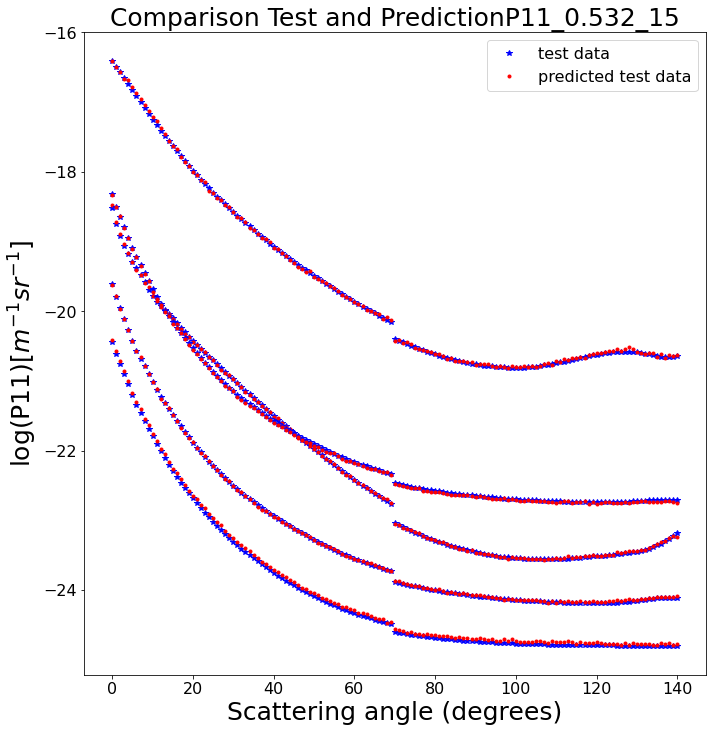

In [84]:
for wl_item in wl_list_P11:
    if len(wl_item) != 0:
        fig, ax = plt.subplots(figsize = (10,10))
        for index in presentation_plot_index:
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_test[wl_item].iloc[index],'b*')
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_pred_fw[wl_item].iloc[index],'r.')

        ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
        ax.set_ylabel('log(P11)[$m^{-1}sr^{-1}$]',fontsize = 25)
        ax.tick_params(labelsize = 16)    
        fig.tight_layout() 
        ax.set_title( 'Comparison Test and Prediction'+wl_item[0],fontsize = 25)
        ax.legend(['test data', 'predicted test data'], fontsize = 16)
        fig.savefig(f'{plot_dir}/phase_data__result_iv'+str(wl_item[0])+'.jpg')

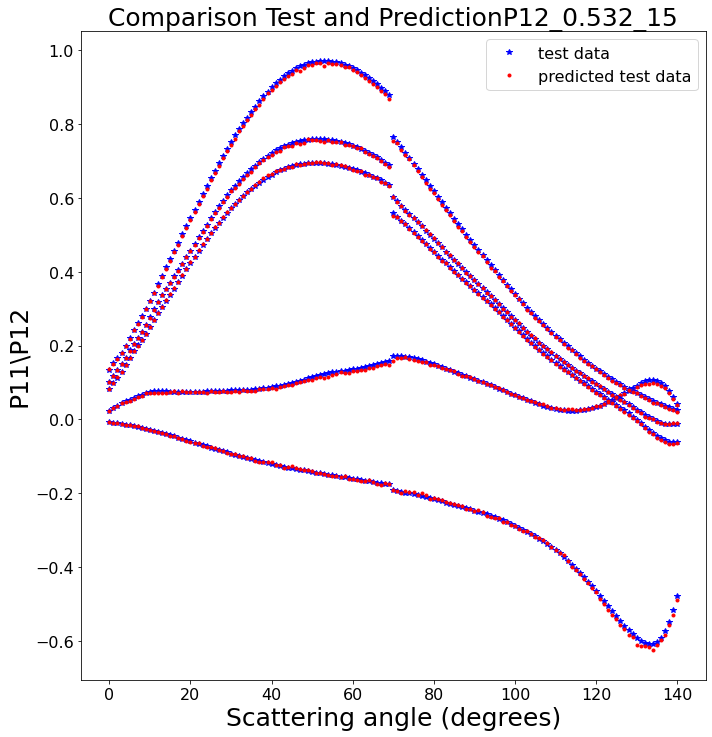

In [85]:
for wl_item in wl_list_P12:
    if len(wl_item) != 0:
        fig, ax = plt.subplots(figsize = (10,10))
        for index in presentation_plot_index:
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_test[wl_item].iloc[index],'b*')
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_pred_fw[wl_item].iloc[index],'r.')
    
    

        ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
        ax.set_ylabel('P11\P12',fontsize = 25)
        ax.tick_params(labelsize = 16)    
        fig.tight_layout() 
        ax.set_title( 'Comparison Test and Prediction'+wl_item[0],fontsize = 25)
        ax.legend(['test data', 'predicted test data'], fontsize = 16)
        fig.savefig(f'{plot_dir}/phase_data__result_iv'+str(wl_item[0])+'.jpg')

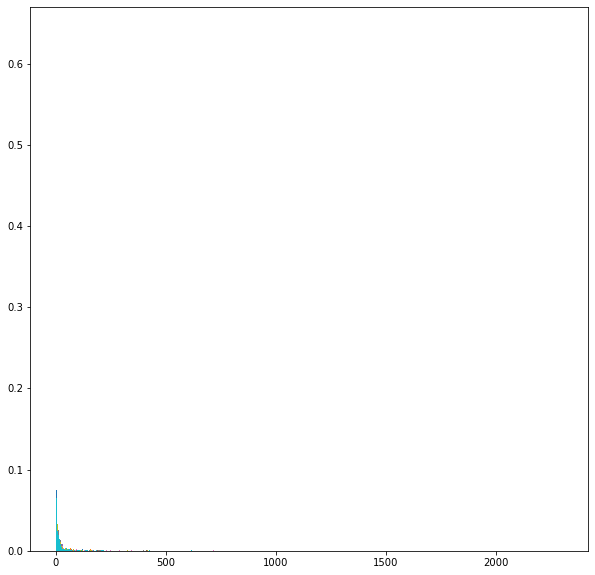

In [86]:
fig, ax = plt.subplots(figsize = (10,10))

x1data = []
x2data = []
y1data = []
y2data = []

for datapoint in presentation_plot_index:
    mu1 = dvar_pred_iv.iloc[datapoint]['R_median']
    sigma1 = dvar_pred_iv.iloc[datapoint]['GSD']
    mu2 = dvar_test.iloc[datapoint]['R_median']
    sigma2 = dvar_test.iloc[datapoint]['GSD']
    Vtot1 = dvar_pred_iv.iloc[datapoint]['V_tot']
    Vtot2 = dvar_test.iloc[datapoint]['V_tot']
    
    
    s1 = np.random.lognormal(mu1, sigma1, 10000)
    s2 = np.random.lognormal(mu2, sigma2, 10000)


    count1, bins1, ignored1 = plt.hist(s1, 10000, density=True, align='mid')
    count2, bins2, ignored2 = plt.hist(s2, 10000, density=True, align='mid')

    x1 = np.linspace(min(bins1), max(bins1), 100000)
    x2 = np.linspace(min(bins2), max(bins2), 100000)

    pdf1 = Vtot1*(np.exp(-(np.log(x1) - mu1)**2 / (2 * sigma1**2)) / (x1 * sigma1 * np.sqrt(2 * np.pi)))
    pdf2 = Vtot2*(np.exp(-(np.log(x2) - mu2)**2 / (2 * sigma2**2)) / (x2 * sigma2 * np.sqrt(2 * np.pi)))

    x1data.append(x1)
    x2data.append(x2)
    y1data.append(pdf1)
    y2data.append(pdf2)


0
1000
2000
5000


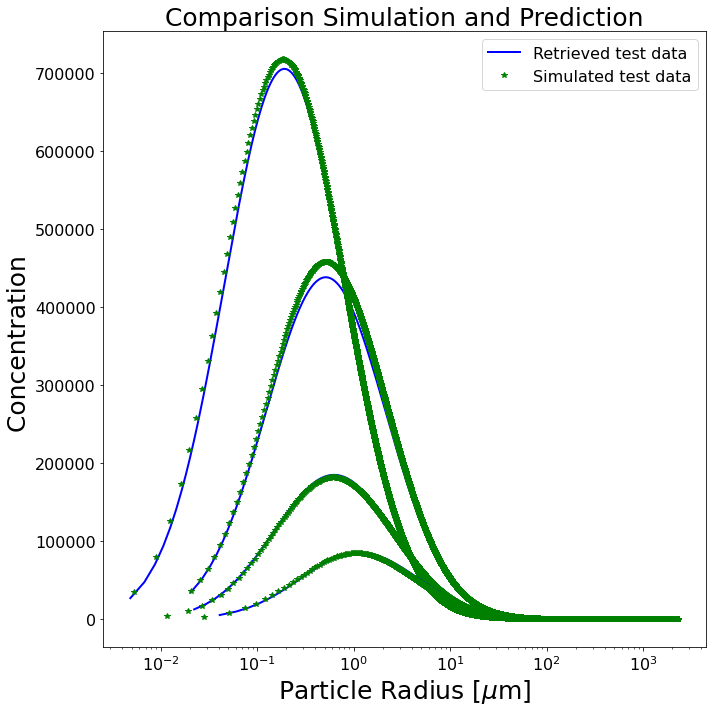

In [87]:
fig, ax = plt.subplots(figsize = (10,10))
for datalen in (0,1,2,3):
    print(presentation_plot_index[datalen])
     
    if datalen == 0:        
        ax.plot(x1data[datalen], y1data[datalen]*1000,'b', linewidth=2,label ='Retrieved test data')
        ax.plot(x2data[datalen], y2data[datalen]*1000, '*g',linewidth=1, label = 'Simulated test data')
    else:
        ax.plot(x1data[datalen], y1data[datalen]*1000,'b', linewidth=2)#,label ='Retrieved test data')
        ax.plot(x2data[datalen], y2data[datalen]*1000, '*g',linewidth=1)#, label = 'Simulated test data')
        
    
ax.legend(['Predicted test data', 'test data'], fontsize = 16)
ax.legend(fontsize = 16)   

ax.set_xlabel('Particle Radius [$\mu$m]',fontsize = 25)
ax.set_ylabel('Concentration ',fontsize = 25)
ax.tick_params(labelsize = 16)    
ax.set_title( 'Comparison Simulation and Prediction',fontsize = 25)
fig.align_labels()

plt.xscale('log')
#plt.yscale('log')
fig.tight_layout() 
fig.savefig(f'{plot_dir}/GSD_GMR_iv.jpg')

# plot correlation test data and predicted test data

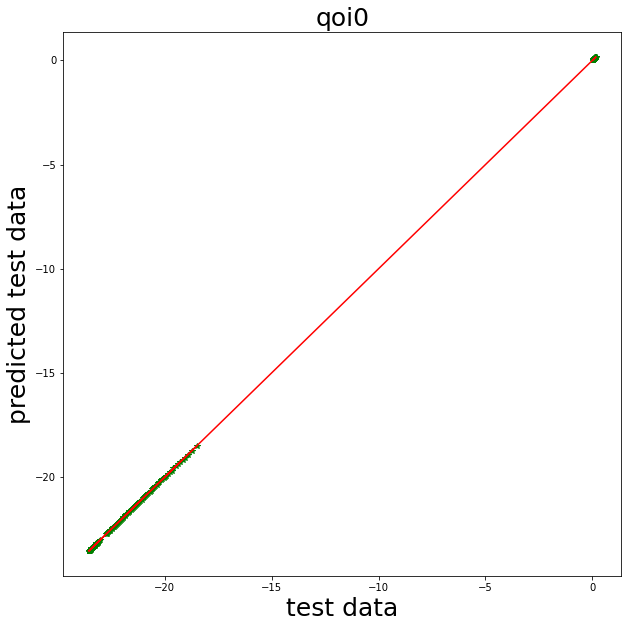

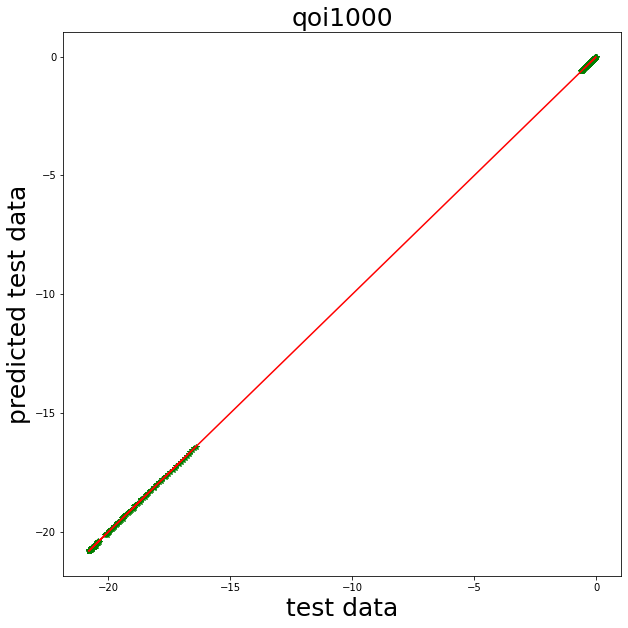

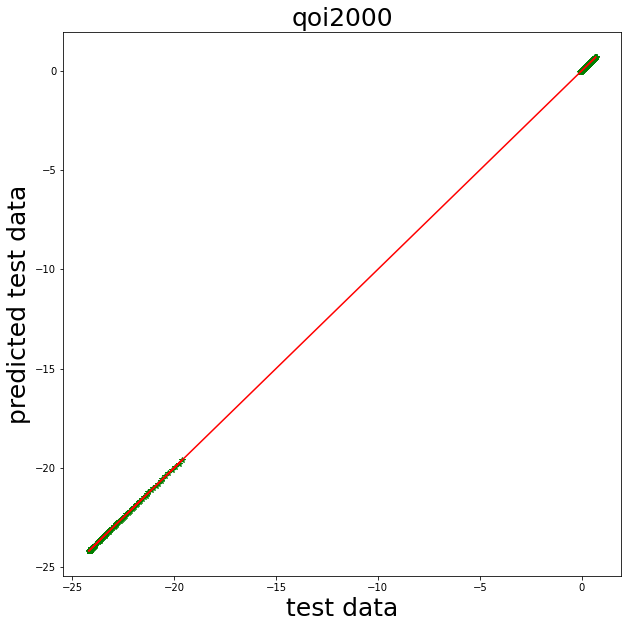

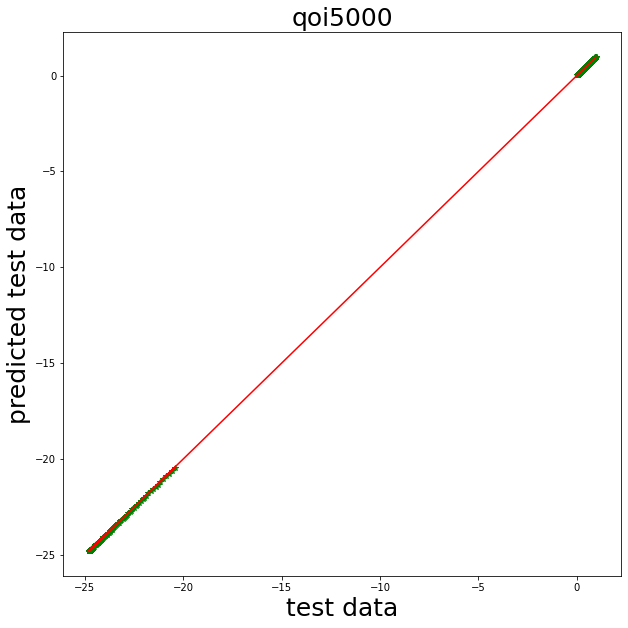

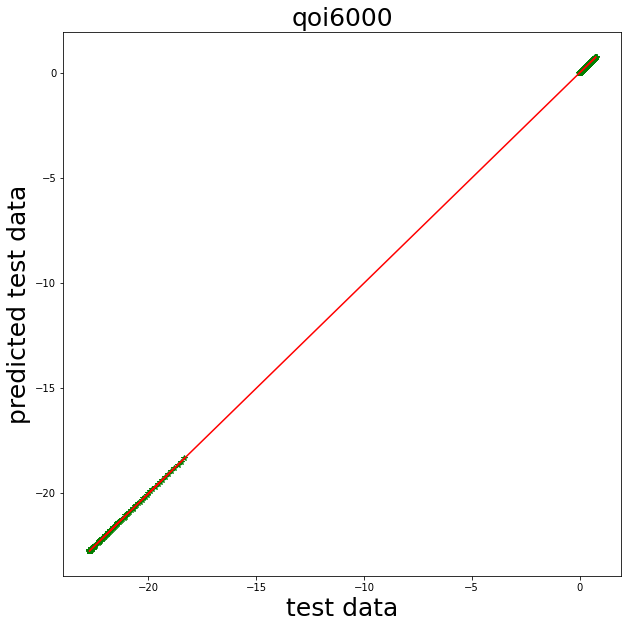

In [88]:
for index in presentation_plot_index:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(qoi_pred_fw.iloc[index],qoi_test.iloc[index],'g*')
    ax.plot(qoi_test.iloc[index],qoi_test.iloc[index],'r')
    ax.set_title('qoi'+str(index), fontsize = 25)
    ax.set_xlabel('test data',fontsize = 25)
    ax.set_ylabel('predicted test data',fontsize = 25)

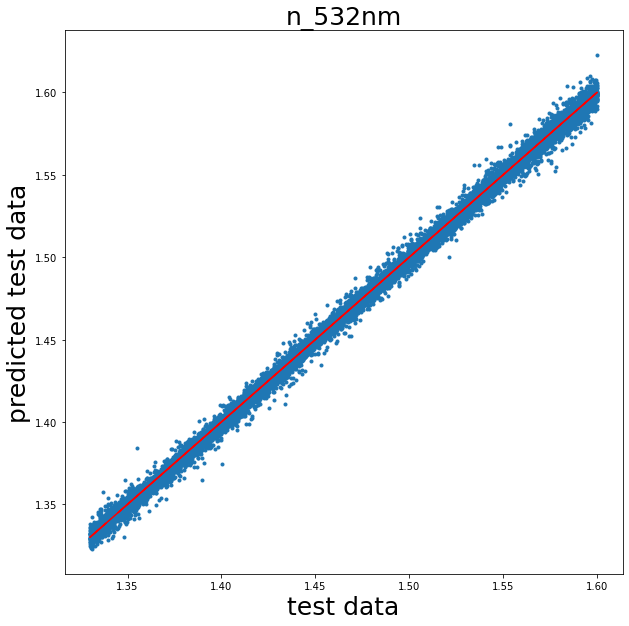

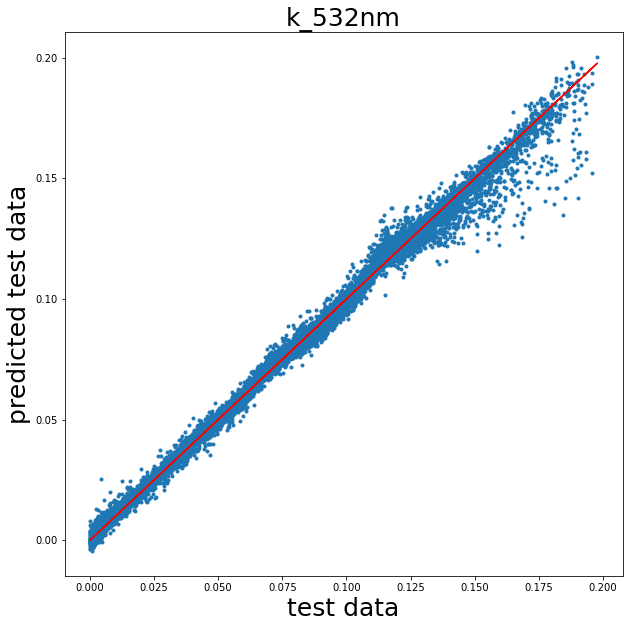

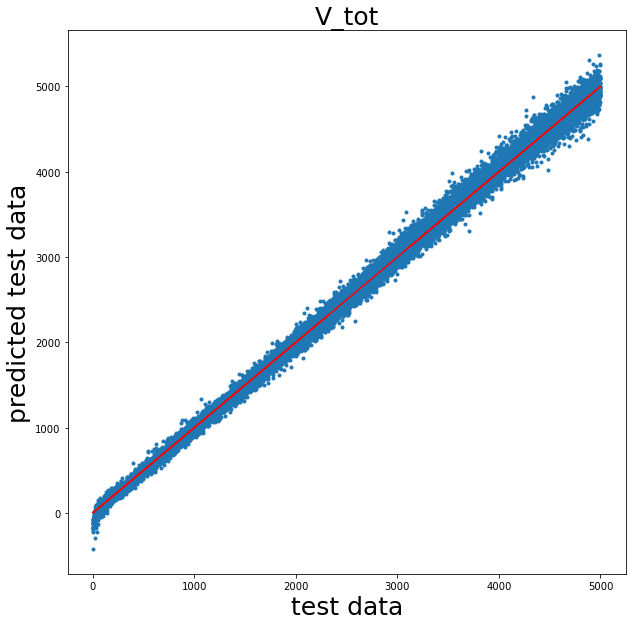

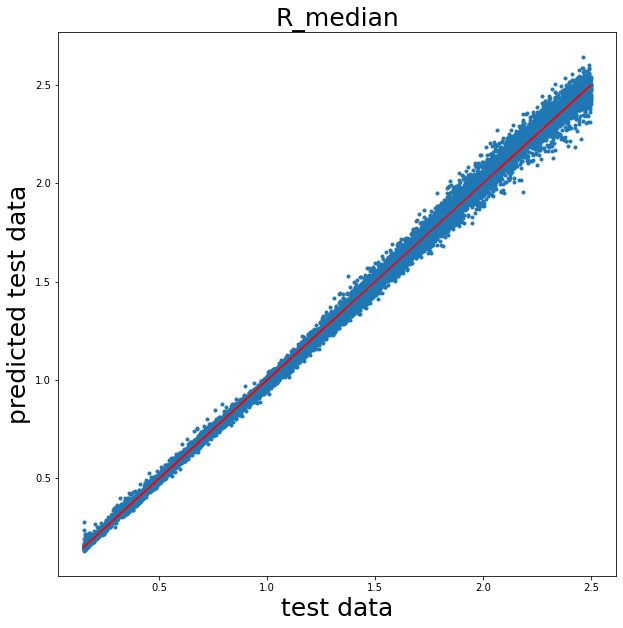

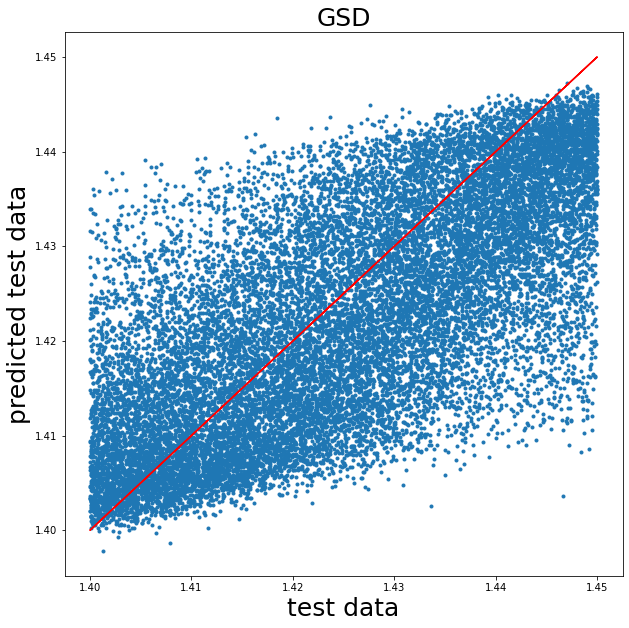

In [89]:
for key in dvar_columns:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(dvar_test[key],dvar_pred_iv[key],".")
    ax.plot(dvar_test[key],dvar_test[key],"r")
    ax.set_title(key, fontsize = 25)
    ax.set_xlabel('test data',fontsize = 25)
    ax.set_ylabel('predicted test data',fontsize = 25)

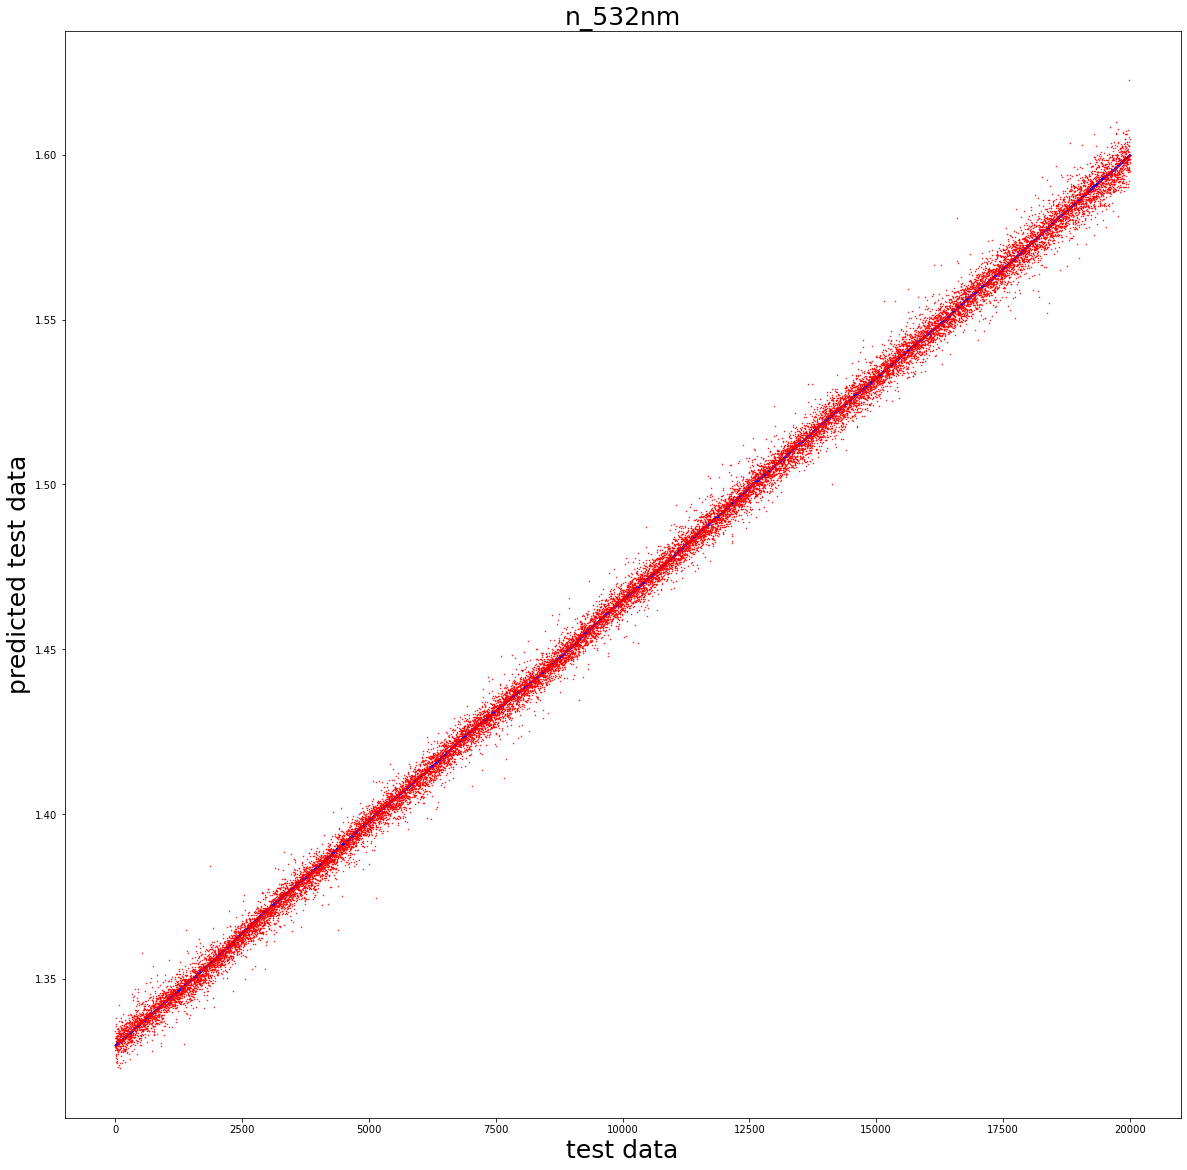

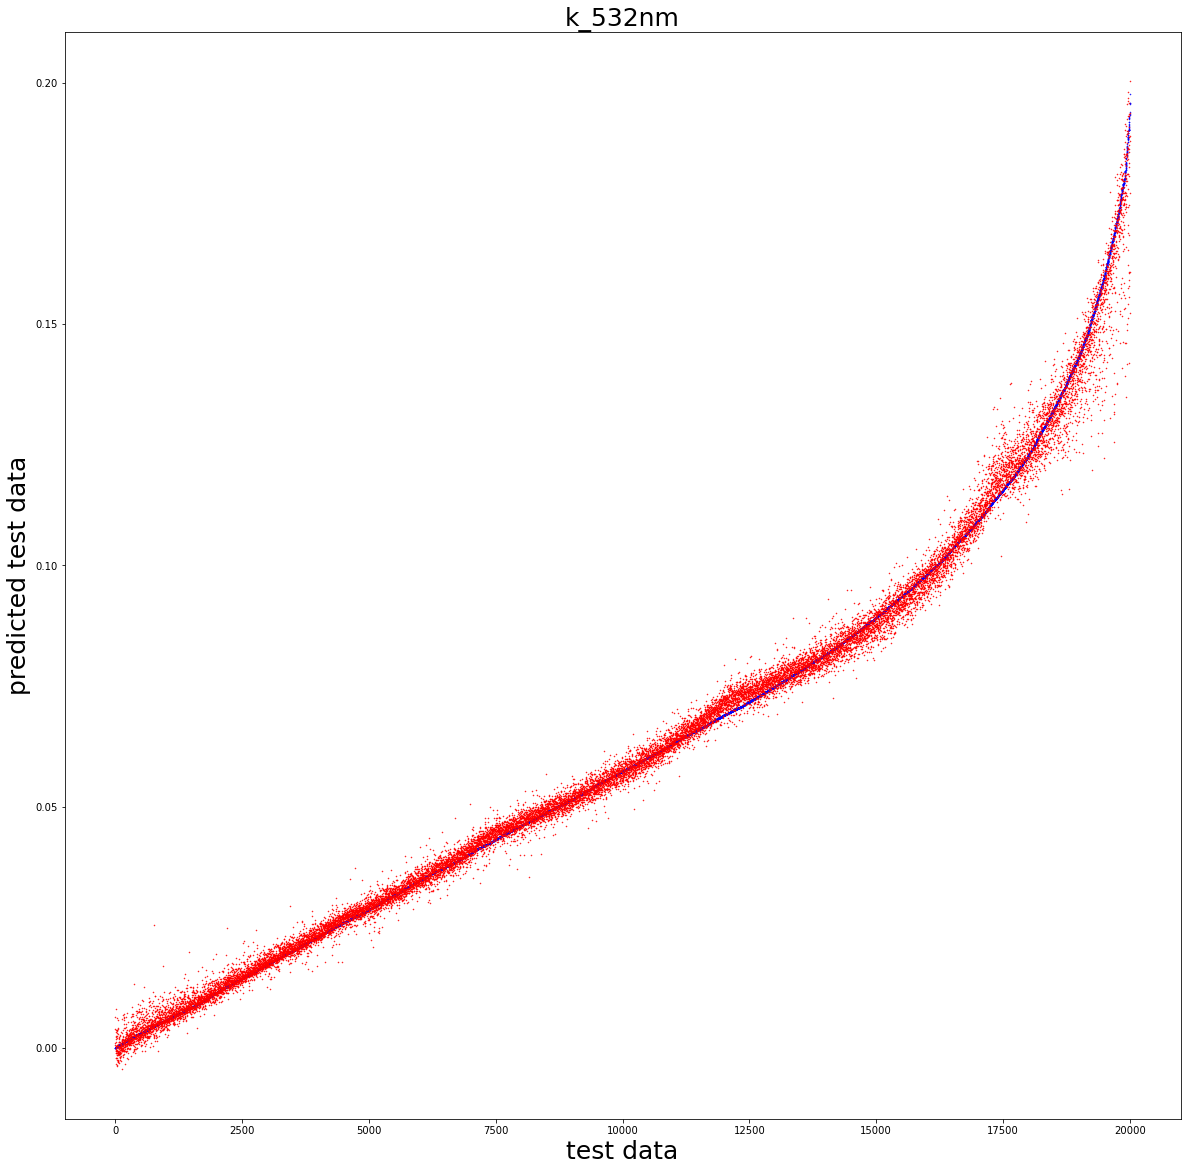

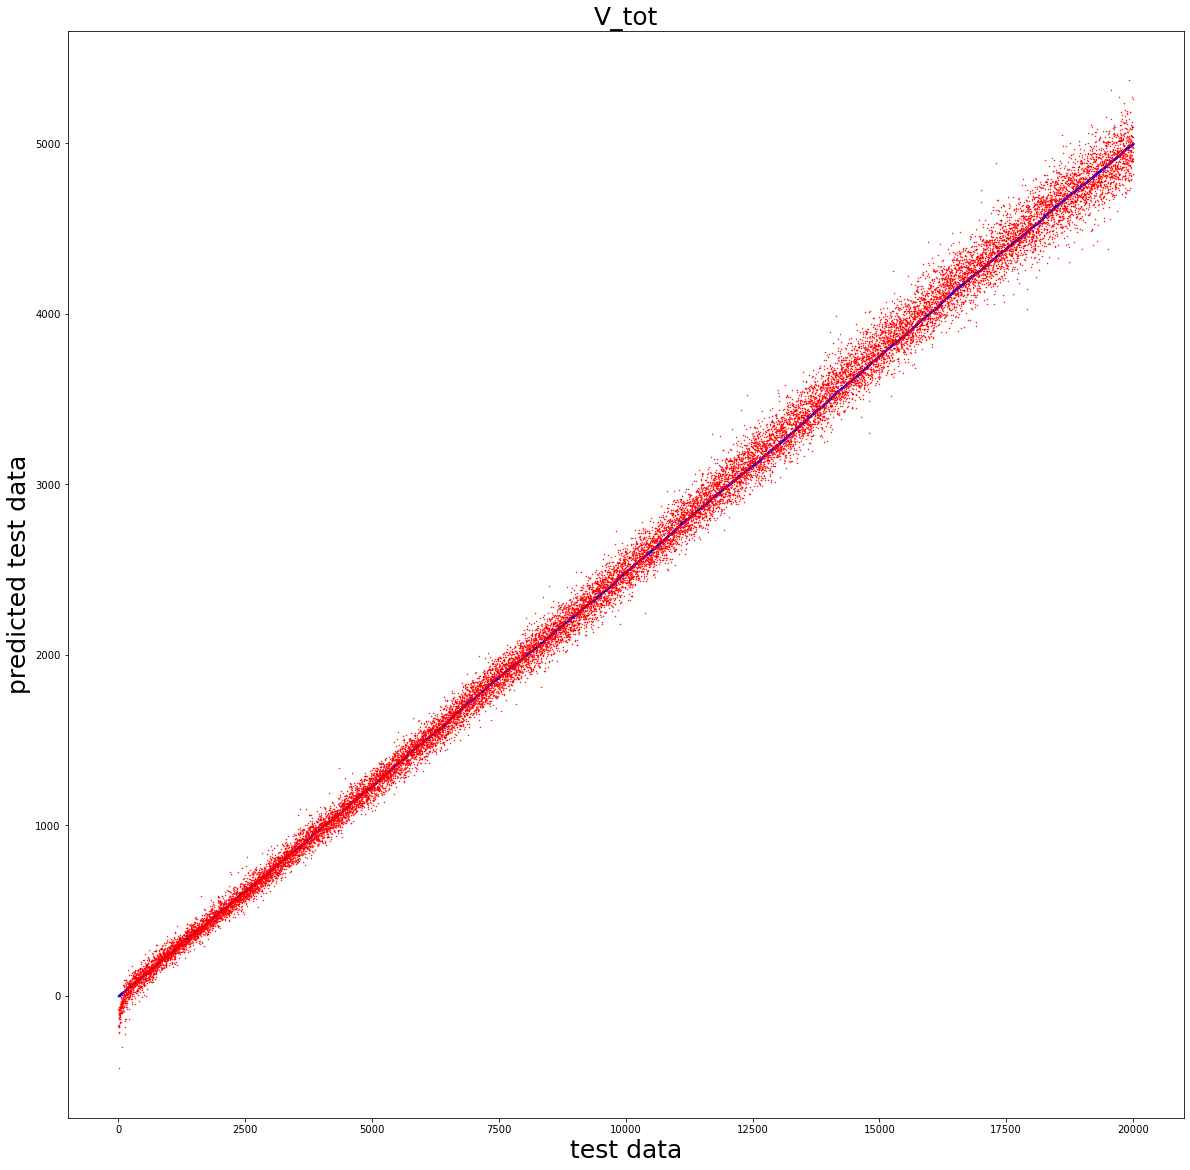

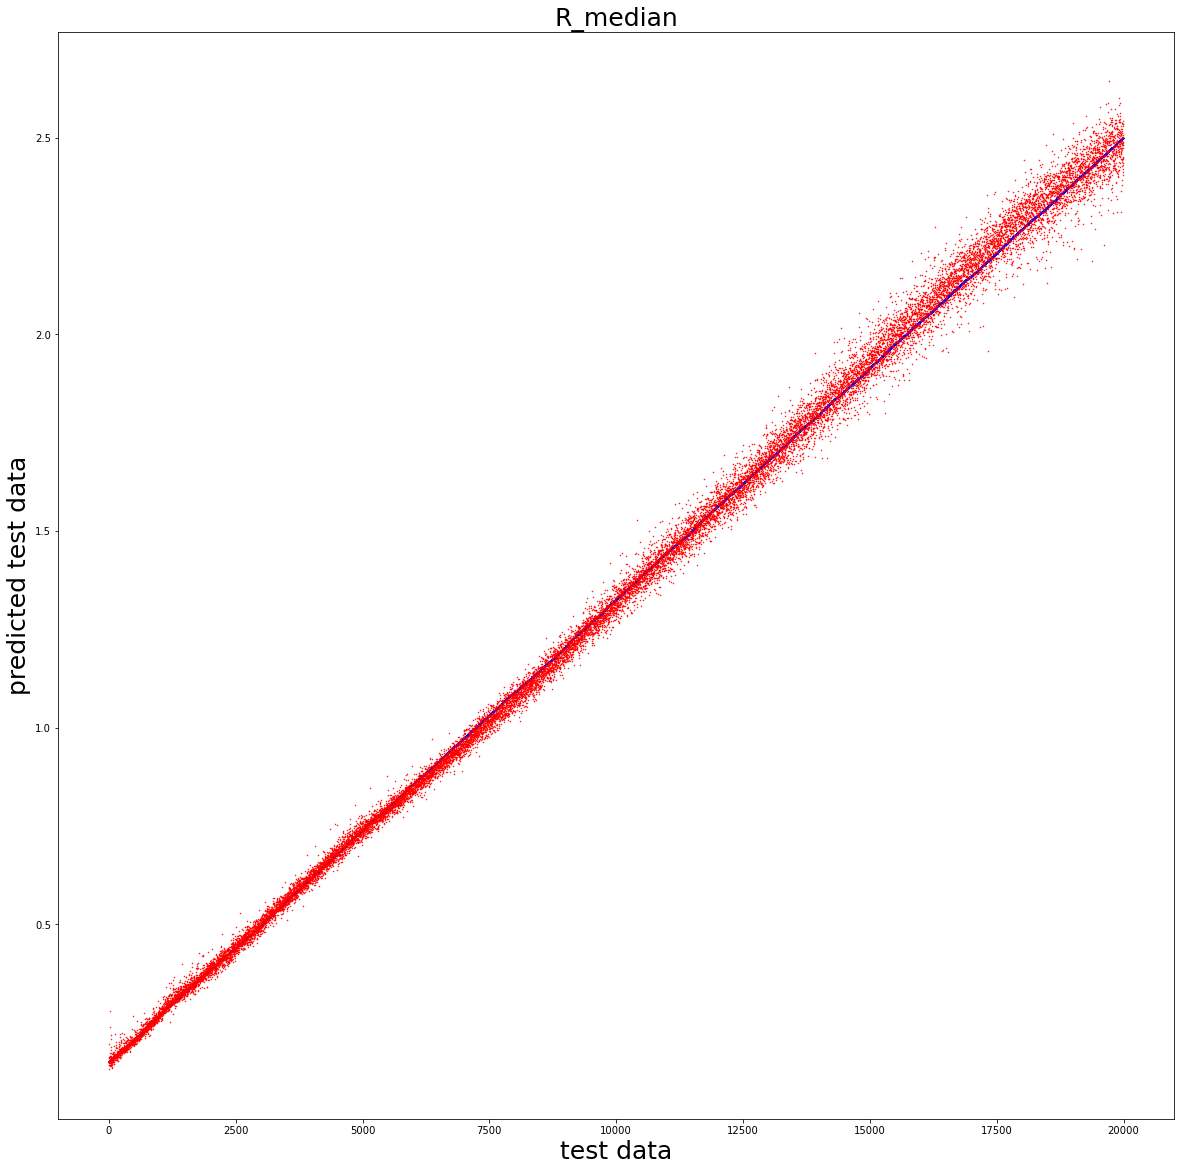

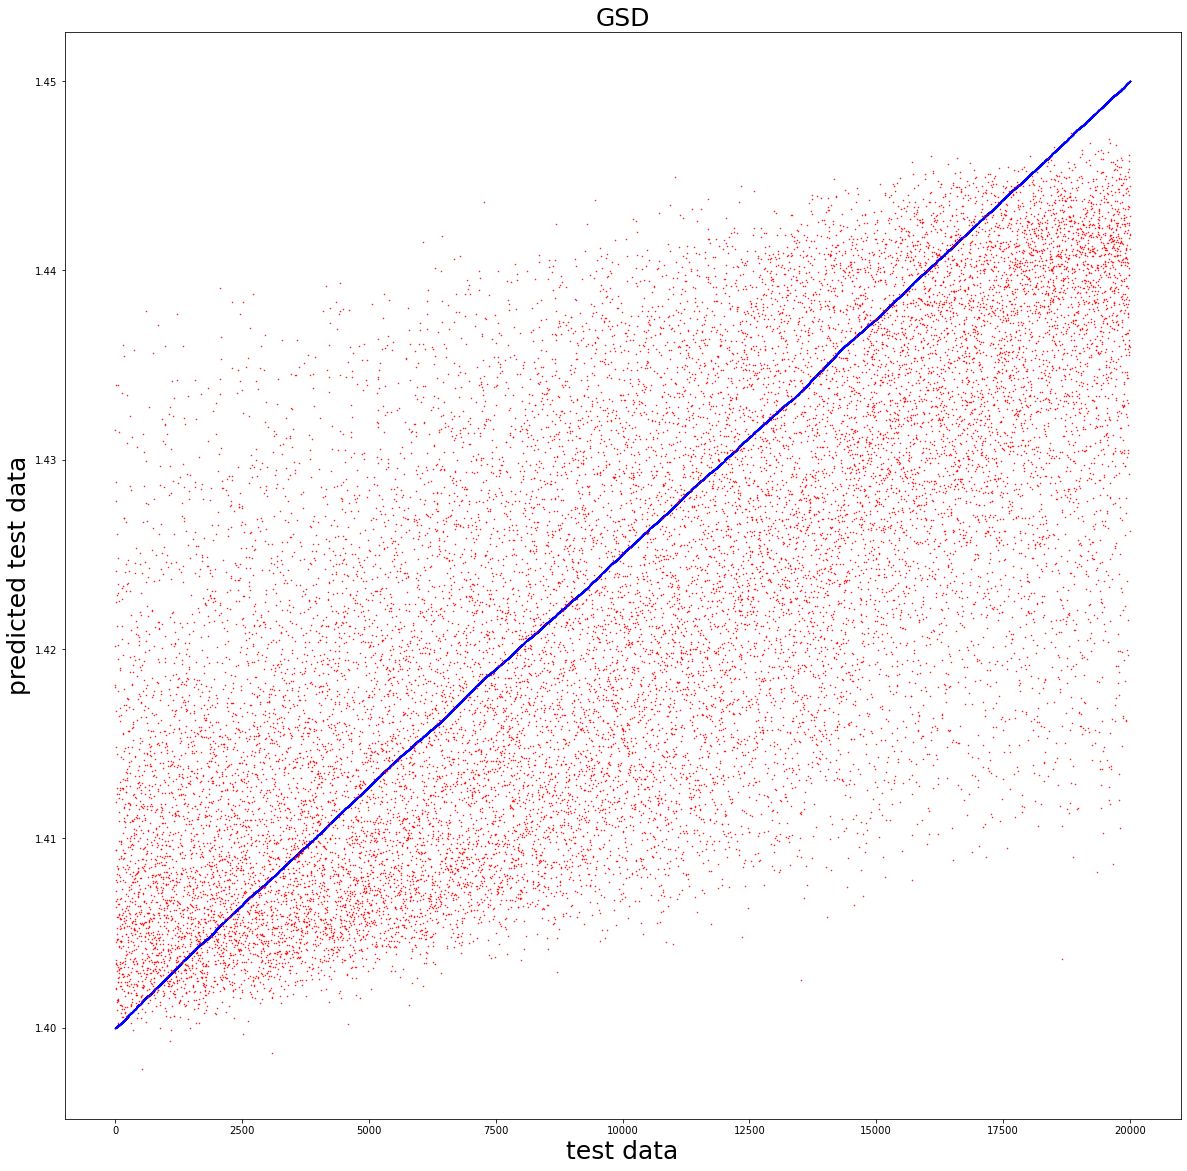

In [90]:
for key in dvar_test.columns:
    dvar_test_help = dvar_test.sort_values(key)
    dvar_pred_iv_df_help = dvar_pred_iv.loc[dvar_test_help.index]

    fig, ax = plt.subplots(figsize=(20, 20))
    ax.plot(np.arange(0,len(dvar_test_help)),dvar_test_help[key],'b.', markersize = '1')
    ax.plot(np.arange(0,len(dvar_pred_iv_df_help)),dvar_pred_iv_df_help[key],'r.', markersize = '1')
    ax.set_title(key, fontsize = 25)
    ax.set_xlabel('test data',fontsize = 25)
    ax.set_ylabel('predicted test data',fontsize = 25)

# plot r2 for forward and inverse model

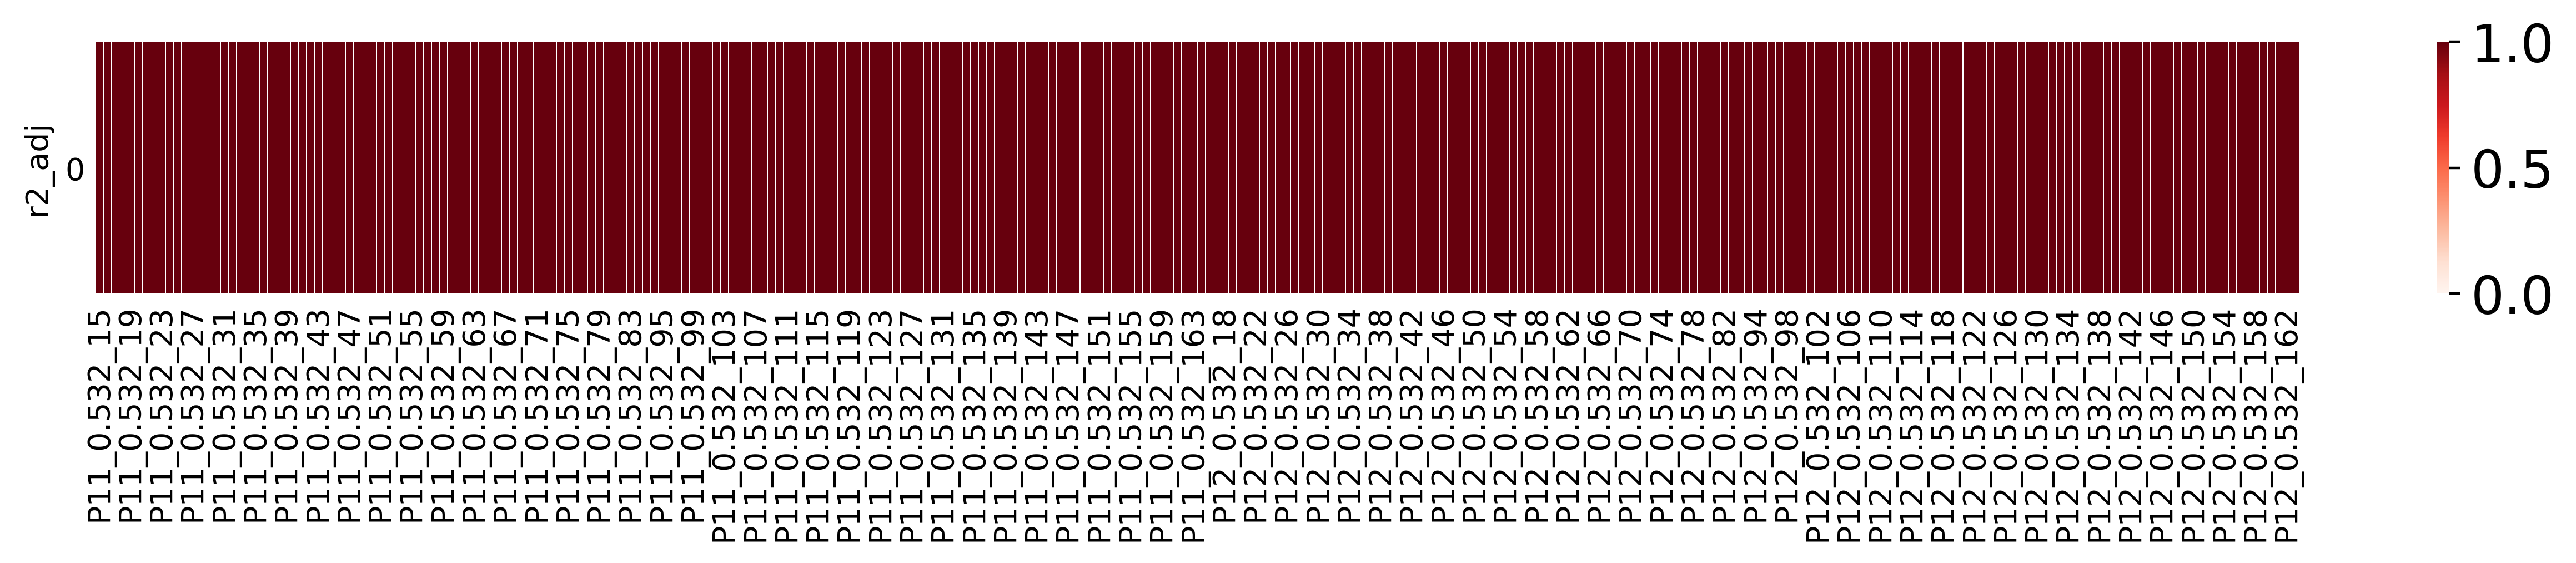

In [91]:
fig, ax = plt.subplots(figsize=(16, 1.5), dpi=400)

sns.heatmap(r2_adj_fw,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
ax.set_ylabel('r2_adj')

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

fig.savefig(f'{plot_dir}/invertible_model_fw_r2_adj.jpg')


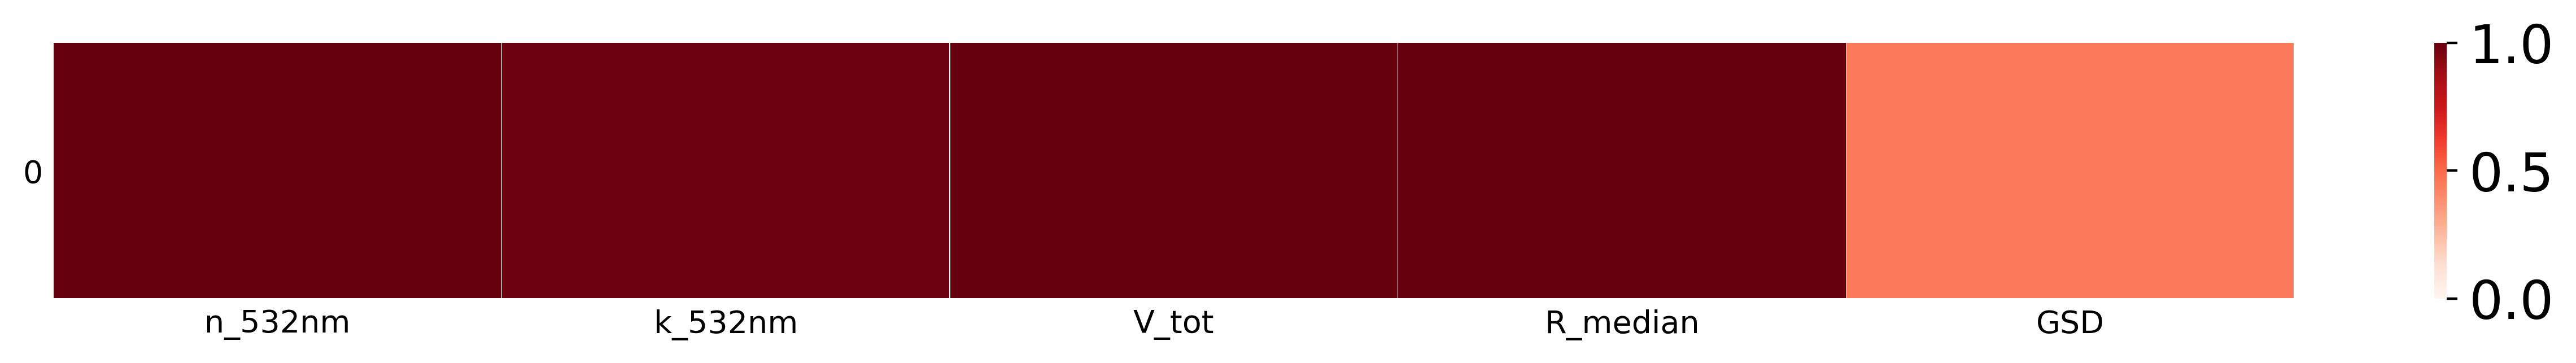

In [92]:
fig, ax = plt.subplots(figsize=(16, 1.5), dpi=400)

sns.heatmap(r2_adj_iv,
            cmap='Reds',
       #     annot=False,
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
      #      annot_kws={'fontsize': 20},
#            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

#fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/invertible_model_inv_r2_adj.jpg')



# Plot Relative Errors / Absolute errors

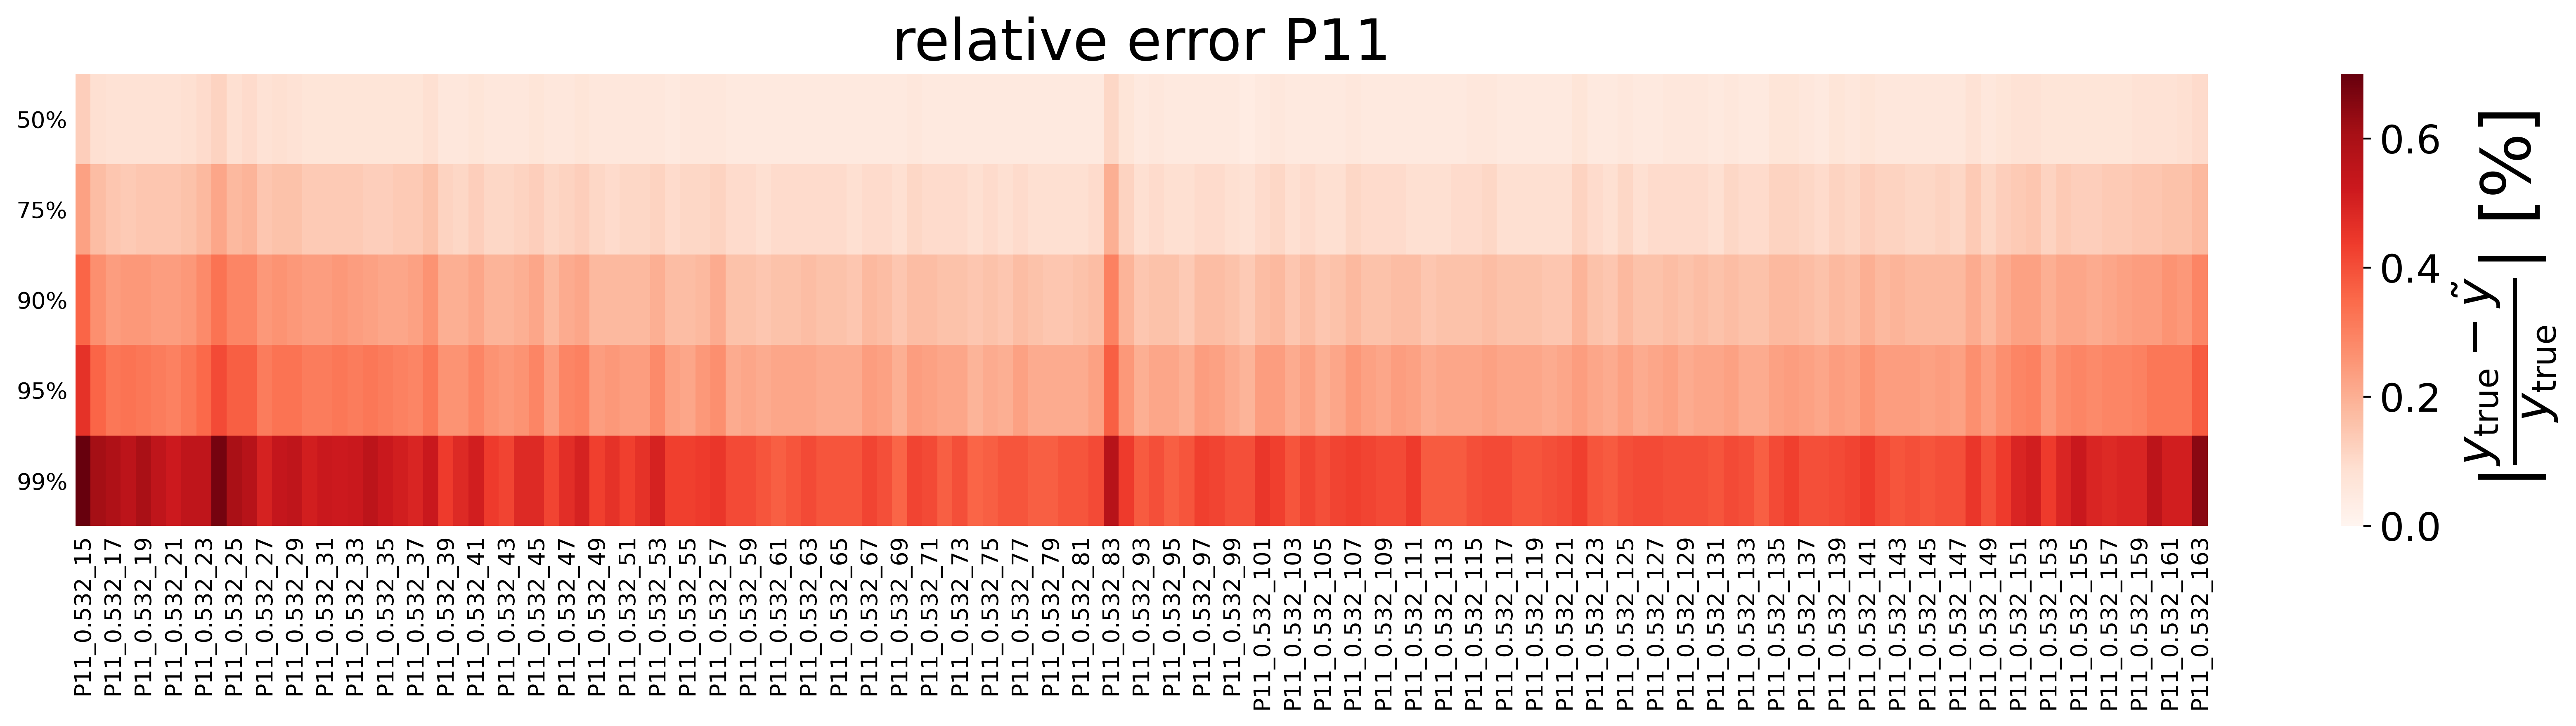

In [93]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table_fw_P11,
            cmap='Reds',
           # annot=True,
           # linewidths=2.,
            vmin=0.,
            vmax=np.max(rel_error_table_fw_P11.max()),
           # annot_kws={'fontsize': 20},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)
ax.set_title('relative error P11', fontsize =25)
fig.tight_layout(rect=(0, 0, 1.05, 1))

fig.savefig(f'{plot_dir}/forward_rel_error_percentiles.jpg')

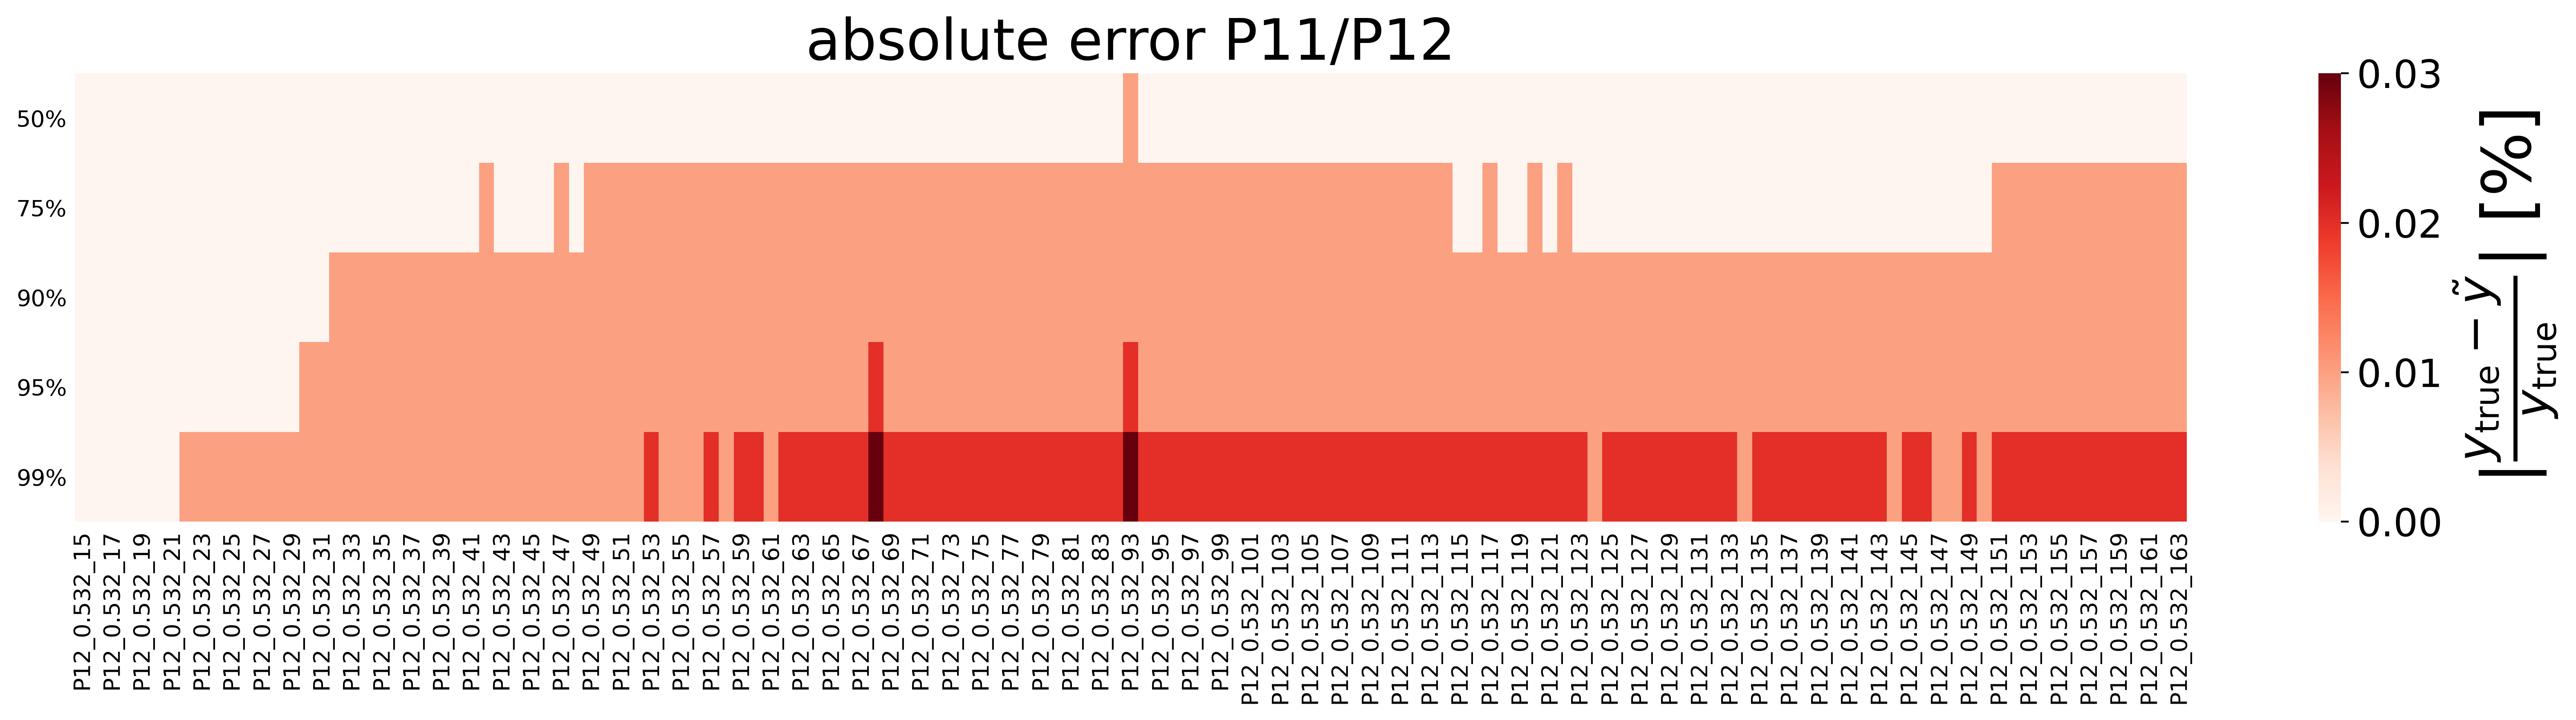

In [94]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(abs_error_table_fw_P12,
            cmap='Reds',
           # annot=True,
           # linewidths=2.,
            vmin=0.,
            vmax=np.max(abs_error_table_fw_P12.max()),
           # annot_kws={'fontsize': 20},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)
ax.set_title('absolute error P11/P12', fontsize =25)
fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/forward_rel_error_percentiles.jpg')

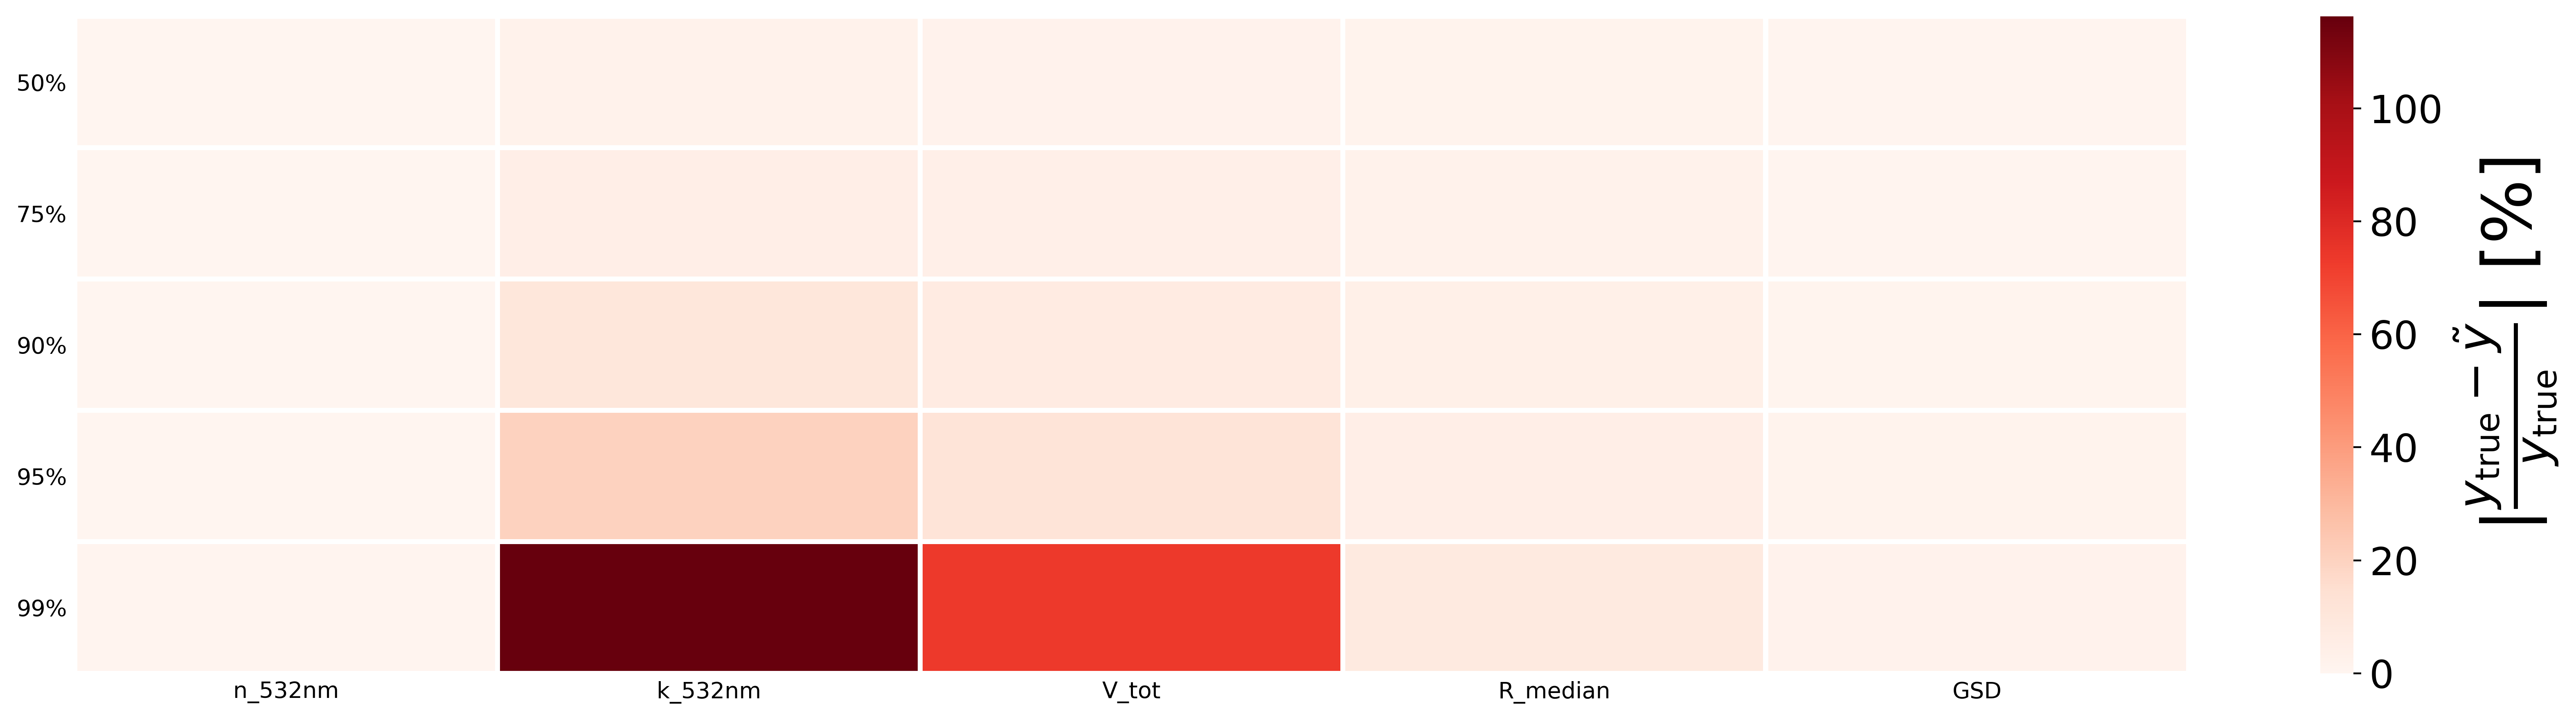

In [95]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table_iv,
            cmap='Reds',
       #     annot=False,
            linewidths=2.,
            vmin=0.,
            vmax=np.max(rel_error_table_iv.max()),
      #      annot_kws={'fontsize': 20},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/invertible_sampling_rel_error_percentiles.jpg')


In [96]:
# Rework plots below

In [97]:
surr.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 644)]             0         
_________________________________________________________________
affine_coupling_block (Affin (None, 644)               201768    
_________________________________________________________________
permutation_layer (Permutati (None, 644)               0         
_________________________________________________________________
affine_coupling_block_1 (Aff (None, 644)               201768    
_________________________________________________________________
permutation_layer_1 (Permuta (None, 644)               0         
_________________________________________________________________
affine_coupling_block_2 (Aff (None, 644)               201768    
Total params: 605,304
Trainable params: 605,304
Non-trainable params: 0
_______________________________________________________

In [98]:
from keras.utils.vis_utils import plot_model

In [99]:
plot_model(surr.model, show_shapes=False,show_layer_names=True,to_file = f'{plot_dir}/model_architecture_invertible.png')


('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [100]:
r2_adj_fw = r2_adj_fw.rename({0: 'r2_adj'}, axis='index')
r2_adj_iv = r2_adj_iv.rename({0: 'r2_adj'}, axis='index')


# create overview plot

In [101]:
'''# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(7,3)

plt.subplot2grid((7,3), (0,0), colspan=3, rowspan=1)
sns.heatmap(r2_adj_fw,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
            xticklabels= False)
plt.tick_params(labelsize = 16)    
plt.title( 'Adjusted R2',fontsize = 25)

plt.subplot2grid((7,3), (1,0), colspan =3, rowspan =1)
sns.heatmap(rel_error_table_fw,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=np.max(rel_error_table_fw.max()),
            xticklabels = False,
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'})
plt.tick_params(labelsize = 16)    
plt.title( 'Relative Error',fontsize = 25)


#plt.subplot2grid((7,3), (2,0),colspan = 3, rowspan = 2)
#sns.heatmap(to_plot_fw,
#            vmin=-1.,
#            vmax=1.,
#            linewidths = 0.01,
#            cmap='coolwarm',)
#plt.tick_params(labelsize = 16)
#plt.title( 'Correlation between DVARs and QOIs',fontsize = 25)

plt.subplot2grid((7,3), (5,0), colspan = 2, rowspan = 2)
for index in presentation_plot_index:
    plot_test_data = plt.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = plt.plot(np.arange(3,len(qoi_pred_fw.columns)+3),qoi_pred_fw.iloc[index],'r.')
plt.xlabel('Scattering angle (degrees)',fontsize = 25)
plt.ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
plt.legend(['Test data', 'Predicted test data'], fontsize = 16)
#get_legend().get_title().set_fontsize('16')


plt.subplot2grid((7,3), (5,2), colspan = 1, rowspan = 1)
for index in qoi_test.index.values:
    plt.plot(qoi_test.iloc[index],qoi_pred_fw.iloc[index],'b*')
plt.title( 'Comparison Test and Prediction',fontsize = 25)    
plt.xlabel('Test data',fontsize = 25)
plt.ylabel('Predicted test data ',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.axline([-25, -25], [-8, -8])


fig.set_size_inches(w=30,h=30)
fig.savefig(f'{plot_dir}/overview_invertible_model_fw.jpg')
'''


"# Plot figure with subplots of different sizes\nfig = plt.figure(1)\n# set up subplot grid\ngridspec.GridSpec(7,3)\n\nplt.subplot2grid((7,3), (0,0), colspan=3, rowspan=1)\nsns.heatmap(r2_adj_fw,\n            cmap='Reds',\n            linewidths=0.01,\n            vmin=0.,\n            vmax=1.,\n            xticklabels= False)\nplt.tick_params(labelsize = 16)    \nplt.title( 'Adjusted R2',fontsize = 25)\n\nplt.subplot2grid((7,3), (1,0), colspan =3, rowspan =1)\nsns.heatmap(rel_error_table_fw,\n            cmap='Reds',\n            linewidths=0.01,\n            vmin=0.,\n            vmax=np.max(rel_error_table_fw.max()),\n            xticklabels = False,\n            cbar_kws={'label': r'$\\left| \x0crac{y_\\mathrm{true} - \tilde{y}}{y_\\mathrm{true}} \right|$ [%]'})\nplt.tick_params(labelsize = 16)    \nplt.title( 'Relative Error',fontsize = 25)\n\n\n#plt.subplot2grid((7,3), (2,0),colspan = 3, rowspan = 2)\n#sns.heatmap(to_plot_fw,\n#            vmin=-1.,\n#            vmax=1.,\n#     

In [102]:
'''# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(7,3)

plt.subplot2grid((7,3), (0,0), colspan=3, rowspan=1)
sns.heatmap(r2_adj_iv,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
            xticklabels= False)
plt.tick_params(labelsize = 16)    
plt.title( 'Adjusted R2',fontsize = 25)

plt.subplot2grid((7,3), (1,0), colspan =3, rowspan =1)
sns.heatmap(rel_error_table_iv,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=np.max(rel_error_table_iv.max()),
            xticklabels = False,
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'})
plt.tick_params(labelsize = 16)    
plt.title( 'Relative Error',fontsize = 25)


#plt.subplot2grid((7,3), (2,0),colspan = 3, rowspan = 2)
#sns.heatmap(to_plot_iv,
#            vmin=-1.,
#            vmax=1.,
#            linewidths = 0.01,
#            cmap='coolwarm',)
#plt.tick_params(labelsize = 16)
#plt.title( 'Correlation between DVARs and QOIs',fontsize = 25)

plt.subplot2grid((7,3), (5,0), colspan = 2, rowspan = 2)
for index in presentation_plot_index:
    plot_test_data = plt.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = plt.plot(np.arange(3,len(qoi_pred_fw.columns)+3),qoi_pred_fw.iloc[index],'r.')
plt.xlabel('Scattering angle (degrees)',fontsize = 25)
plt.ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
plt.legend(['Test data', 'Predicted test data'], fontsize = 16)
#get_legend().get_title().set_fontsize('16')


plt.subplot2grid((7,3), (5,2), colspan = 1, rowspan = 1)
for index in qoi_test.index.values:
    plt.plot(qoi_test.iloc[index],qoi_pred_fw.iloc[index],'b*')
plt.title( 'Comparison Test and Prediction',fontsize = 25)    
plt.xlabel('Test data',fontsize = 25)
plt.ylabel('Predicted test data ',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.axline([-25, -25], [-8, -8])


fig.set_size_inches(w=30,h=30)
fig.savefig(f'{plot_dir}/overview_invertible_model_iv.jpg')
'''


"# Plot figure with subplots of different sizes\nfig = plt.figure(1)\n# set up subplot grid\ngridspec.GridSpec(7,3)\n\nplt.subplot2grid((7,3), (0,0), colspan=3, rowspan=1)\nsns.heatmap(r2_adj_iv,\n            cmap='Reds',\n            linewidths=0.01,\n            vmin=0.,\n            vmax=1.,\n            xticklabels= False)\nplt.tick_params(labelsize = 16)    \nplt.title( 'Adjusted R2',fontsize = 25)\n\nplt.subplot2grid((7,3), (1,0), colspan =3, rowspan =1)\nsns.heatmap(rel_error_table_iv,\n            cmap='Reds',\n            linewidths=0.01,\n            vmin=0.,\n            vmax=np.max(rel_error_table_iv.max()),\n            xticklabels = False,\n            cbar_kws={'label': r'$\\left| \x0crac{y_\\mathrm{true} - \tilde{y}}{y_\\mathrm{true}} \right|$ [%]'})\nplt.tick_params(labelsize = 16)    \nplt.title( 'Relative Error',fontsize = 25)\n\n\n#plt.subplot2grid((7,3), (2,0),colspan = 3, rowspan = 2)\n#sns.heatmap(to_plot_iv,\n#            vmin=-1.,\n#            vmax=1.,\n#     

In [103]:
configs = pd.read_csv(f'{model_dir}/configs.csv')
configs.columns

Index(['Unnamed: 0', 'MAE_train', 'MAE_val', 'MAPE_train', 'MAPE_val',
       'MSE_train', 'MSE_val', 'median_percentile_max_error_train',
       'median_percentile_max_error_val', '90_percentile_max_error_train',
       '90_percentile_max_error_val', 'r2_train', 'r2_val', 'r2_adj_train',
       'r2_adj_val', 'MAE_train_dvar', 'MAE_val_dvar', 'MAPE_train_dvar',
       'MAPE_val_dvar', 'MSE_train_dvar', 'MSE_val_dvar',
       'median_percentile_max_error_train_dvar',
       'median_percentile_max_error_val_dvar',
       '90_percentile_max_error_train_dvar',
       '90_percentile_max_error_val_dvar', 'r2_train_dvar', 'r2_val_dvar',
       'r2_adj_train_dvar', 'r2_adj_val_dvar', 'time_this_iter_s', 'done',
       'timesteps_total', 'episodes_total', 'training_iteration',
       'experiment_id', 'date', 'timestamp', 'time_total_s', 'pid', 'hostname',
       'node_ip', 'time_since_restore', 'timesteps_since_restore',
       'iterations_since_restore', 'trial_id',
       'config/activation_f

In [104]:
store_results = pd.DataFrame()


In [105]:
store_results['data_file'] = configs['config/datafile']
store_results['batch_size'] = configs['config/batch_size']
store_results['learning_rate'] = configs['config/learning_rate']
store_results['n_blocks'] = configs['config/n_blocks']
store_results['n_depth'] = configs['config/n_depth']
store_results['n_width'] = configs['config/n_width']
store_results['weight_x'] = configs['config/weight_x']
store_results['weight_y'] = configs['config/weight_y']
store_results['weight_z'] = configs['config/weight_z']
store_results['weight_artificial'] = configs['config/weight_artificial']
store_results['weight_reconstruction'] = configs['config/weight_reconstruction']
store_results['r2_val_qoi_mean'] = configs['r2_val']
store_results['r2_test_qoi_mean'] = r2_adj_fw.mean(axis =1).values
if 'P11' in qoi_columns[0]:
    store_results['rel_error95%_qoi_P11_max'] = rel_error_table_fw_P11.max(axis = 1)['95%']
    store_results['abs_error95%_qoi_P11_max'] = abs_error_table_fw_P11.max(axis = 1)['95%']
else:
    store_results['rel_error95%_qoi_P11_max'] = 0
    store_results['abs_error95%_qoi_P11_max'] = 0
if 'P12' in qoi_columns[-1]:
    store_results['rel_error95%_qoi_P12_max'] = rel_error_table_fw_P12.max(axis = 1)['95%']
    store_results['abs_error95%_qoi_P12_max'] = abs_error_table_fw_P12.max(axis = 1)['95%']
else:    
    store_results['rel_error95%_qoi_P12_max'] = 0
    store_results['rel_error95%_qoi_P12_max'] = 0
store_results['MAE_qoi_max'] = MAE_all_qoi.max(axis= 1).values
store_results['MAPE%_qoi_max'] = MAPE_all_qoi.max(axis= 1).values
store_results['explained_variance_qoi_min'] = EVS_all_df.min(axis = 1)

store_results['r2_val_dvar_mean'] = configs['r2_val_dvar']
store_results['r2_test_dvar_mean'] = r2_adj_iv.mean(axis = 1).values



store_results['r2_test_dvar_V'] = r2_adj_iv['V_tot']['r2_adj']
store_results['rel_error95%_dvar_V'] = rel_error_table_iv['V_tot']['95%']
store_results['abs_error95%_dvar_V'] = abs_error_table_iv['V_tot']['95%']
store_results['MAE_dvar_V'] = MAE_all_dvar['V_tot'].values
store_results['MAPE%_dvar_V'] = MAPE_all_dvar['V_tot'].values
store_results['explained_variance_dvar_V'] = EVS_dvar['V_tot']

store_results['r2_test_dvar_R'] = r2_adj_iv['R_median']['r2_adj']
store_results['rel_error95%_dvar_R'] = rel_error_table_iv['R_median']['95%']
store_results['abs_error95%_dvar_R'] = abs_error_table_iv['R_median']['95%']
store_results['MAE_dvar_R'] = MAE_all_dvar['R_median'].values
store_results['MAPE%_dvar_R'] = MAPE_all_dvar['R_median'].values
store_results['explained_variance_dvar_R'] = EVS_dvar['R_median']

store_results['r2_test_dvar_GSD'] = r2_adj_iv['GSD']['r2_adj']
store_results['rel_error95%_dvar_GSD'] = rel_error_table_iv['GSD']['95%']
store_results['abs_error95%_dvar_GSD'] = abs_error_table_iv['GSD']['95%']
store_results['MAE_dvar_GSD'] = MAE_all_dvar['GSD'].values
store_results['MAPE%_dvar_GSD'] = MAPE_all_dvar['GSD'].values
store_results['explained_variance_dvar_GSD'] = EVS_dvar['GSD']

if 'n' in dvar_columns:  
    store_results['r2_test_dvar_n'] = r2_adj_iv['n']['r2_adj']
    store_results['rel_error95%_dvar_n'] = rel_error_table_iv['n']['95%']
    store_results['abs_error95%_dvar_n'] = abs_error_table_iv['n']['95%']
    store_results['MAE_dvar_n'] = MAE_all_dvar['n'].values
    store_results['MAPE%_dvar_n'] = MAPE_all_dvar['n'].values
    store_results['explained_variance_dvar_n'] = EVS_dvar['n']
else:
    store_results['r2_test_dvar_n'] = 0
    store_results['rel_error95%_dvar_n'] = 0
    store_results['abs_error95%_dvar_n'] = 0
    store_results['MAE_dvar_n'] = 0
    store_results['MAPE%_dvar_n'] = 0
    store_results['explained_variance_dvar_n'] = 0   



if 'n_532nm' in dvar_columns:    
    store_results['r2_test_dvar_n_532'] = r2_adj_iv['n_532nm']['r2_adj']
    store_results['rel_error95%_dvar_n_532'] = rel_error_table_iv['n_532nm']['95%']
    store_results['abs_error95%_dvar_n_532'] = abs_error_table_iv['n_532nm']['95%']
    store_results['MAE_dvar_n_532'] = MAE_all_dvar['n_532nm'].values
    store_results['MAPE%_dvar_n_532'] = MAPE_all_dvar['n_532nm'].values
    store_results['explained_variance_dvar_n_532'] = EVS_dvar['n_532nm']

else:
    store_results['r2_test_dvar_n_532'] = 0
    store_results['rel_error95%_dvar_n_532'] = 0
    store_results['abs_error95%_dvar_n_532'] = 0
    store_results['MAE_dvar_n_532'] = 0
    store_results['MAPE%_dvar_n_532'] = 0
    store_results['explained_variance_dvar_n_532'] = 0


if 'k_532nm' in dvar_columns:    
    store_results['r2_test_dvar_k_532'] = r2_adj_iv['k_532nm']['r2_adj']
    store_results['rel_error95%_dvar_k_532'] = rel_error_table_iv['k_532nm']['95%']
    store_results['abs_error95%_dvar_k_532'] = abs_error_table_iv['k_532nm']['95%']
    store_results['MAE_dvar_k_532'] = MAE_all_dvar['k_532nm'].values
    store_results['MAPE%_dvar_k_532'] = MAPE_all_dvar['k_532nm'].values
    store_results['explained_variance_dvar_k_532'] = EVS_dvar['k_532nm']

else:
    store_results['r2_test_dvar_k_532'] = 0
    store_results['rel_error95%_dvar_k_532'] = 0
    store_results['abs_error95%_dvar_k_532'] = 0
    store_results['MAE_dvar_k_532'] = 0
    store_results['MAPE%_dvar_k_532'] = 0
    store_results['explained_variance_dvar_k_532'] = 0
    
if 'n_450nm' in dvar_columns:  
    store_results['r2_test_dvar_n_450'] = r2_adj_iv['n_450nm']['r2_adj']
    store_results['rel_error95%_dvar_n_450'] = rel_error_table_iv['n_450nm']['95%']
    store_results['abs_error95%_dvar_n_450'] = abs_error_table_iv['n_450nm']['95%']
    store_results['MAE_dvar_n_450'] = MAE_all_dvar['n_450nm'].values
    store_results['MAPE%_dvar_n_450'] = MAPE_all_dvar['n_450nm'].values
    store_results['explained_variance_dvar_n_450'] = EVS_dvar['n_450nm']
    
else:
    store_results['r2_test_dvar_n_450'] = 0
    store_results['rel_error95%_dvar_n_450'] = 0
    store_results['abs_error95%_dvar_n_450'] = 0
    store_results['MAE_dvar_n_450'] = 0
    store_results['MAPE%_dvar_n_450'] = 0
    store_results['explained_variance_dvar_n_450'] = 0
    
if 'k_450nm' in dvar_columns:  
    store_results['r2_test_dvar_k_450'] = r2_adj_iv['k_450nm']['r2_adj']
    store_results['rel_error95%_dvar_k_450'] = rel_error_table_iv['k_450nm']['95%']
    store_results['abs_error95%_dvar_k_450'] = abs_error_table_iv['k_450nm']['95%']
    store_results['MAE_dvar_k_450'] = MAE_all_dvar['k_450nm'].values
    store_results['MAPE%_dvar_k_450'] = MAPE_all_dvar['k_450nm'].values
    store_results['explained_variance_dvar_k_450'] = EVS_dvar['k_450nm']
    
else:
    store_results['r2_test_dvar_k_450'] = 0
    store_results['rel_error95%_dvar_k_450'] = 0
    store_results['abs_error95%_dvar_k_450'] = 0
    store_results['MAE_dvar_k_450'] = 0
    store_results['MAPE%_dvar_k_450'] = 0
    store_results['explained_variance_dvar_k_450'] = 0
    
if 'n_630nm' in dvar_columns:    
    store_results['r2_test_dvar_n_630'] = r2_adj_iv['n_630nm']['r2_adj']
    store_results['rel_error95%_dvar_n_630'] = rel_error_table_iv['n_630nm']['95%']
    store_results['abs_error95%_dvar_n_630'] = abs_error_table_iv['n_630nm']['95%']
    store_results['MAE_dvar_n_630'] = MAE_all_dvar['n_630nm'].values
    store_results['MAPE%_dvar_n_630'] = MAPE_all_dvar['n_630nm'].values
    store_results['explained_variance_dvar_n_630'] = EVS_dvar['n_630nm']
else:
    store_results['r2_test_dvar_n_630'] = 0
    store_results['rel_error95%_dvar_n_630'] = 0
    store_results['abs_error95%_dvar_n_630'] = 0
    store_results['MAE_dvar_n_630'] =0
    store_results['MAPE%_dvar_n_630'] =0
    store_results['explained_variance_dvar_n_630'] = 0
      
    
if 'k_630nm' in dvar_columns:    
    store_results['r2_test_dvar_k_630'] = r2_adj_iv['k_630nm']['r2_adj']
    store_results['rel_error95%_dvar_k_630'] = rel_error_table_iv['k_630nm']['95%']
    store_results['abs_error95%_dvar_k_630'] = abs_error_table_iv['k_630nm']['95%']
    store_results['MAE_dvar_k_630'] = MAE_all_dvar['k_630nm'].values
    store_results['MAPE%_dvar_k_630'] = MAPE_all_dvar['k_630nm'].values
    store_results['explained_variance_dvar_k_630'] = EVS_dvar['k_630nm']
else:
    store_results['r2_test_dvar_k_630'] = 0
    store_results['rel_error95%_dvar_k_630'] = 0
    store_results['abs_error95%_dvar_k_630'] = 0
    store_results['MAE_dvar_k_630'] =0
    store_results['MAPE%_dvar_k_630'] =0
    store_results['explained_variance_dvar_k_630'] = 0
    







store_results['preprocessor_x'] = configs['config/preprocessor_x']
store_results['preprocessor_y'] = configs['config/preprocessor_y']

KeyError: 'n'

In [ ]:
store_results.to_csv(f'{model_dir}/results_summary1.csv')


In [ ]:
store_results

In [ ]:
model_dir